# EGM Signal Prediction: Autoregressive Models

This repository contains code and resources for predicting EGM (Electrogram) signals using autoregressive models. The goal is to take $2.5$ seconds of EGM data at a sampling rate of $500$ Hz, and use the first $2$ seconds to predict the next $0.5$ seconds.

In [28]:
import os
import re
import pickle
import lzma
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import pacf, adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.regression.recursive_ls import RecursiveLS

## 1. Stochastic Modeling of Bio-Signals

Let $(\Omega, \mathcal{F}, \mathbb{P})$ be a probability space. We define the discrete-time intracardiac electrogram (EGM) signal as a real-valued stochastic process $(X_t)_{t \in \mathbb{Z}}$, where each $X_t \in \mathcal{L}^2(\Omega, \mathcal{F}, \mathbb{P})$ (i.e., $E[X_t^2] < \infty$ for all $t$). For the purpose of linear prediction, we generally assume the process is weakly stationary (or second-order stationary). This implies that the first two moments are time-invariant:

1. $\mathbb{E}[X_t] = \mu < \infty$ for all $t \in \mathbb{Z}$ (constant mean)
2. $\mathbb{C}\text{ov}(X_t, X_{t+h}) = \gamma(h)$ for all $t, h \in \mathbb{Z}$ (autocovariance depends only on lag $h$)

The theoretical justification for modeling EGMs using autoregressive structures stems from Wold's Decomposition Theorem. Any zero-mean, purely non-deterministic stationary time series $X_t$​ can be expressed as an infinite moving average representation:

$$
X_t = \sum_{j=0}^{\infty} \psi_j \varepsilon_{t-j},
$$

where $\psi_0 = 1$ and $\sum_{j=0}^{\infty} \psi_j^2 < \infty$, and $\{\varepsilon_t\}_{t \in \mathbb{Z}}$ is a white noise process with zero mean and variance $\sigma^2$. This representation indicates that the current value of the process can be expressed as a linear combination of past white noise innovations.

Note that in practical applications, the assumption of stationarity may not hold perfectly for EGM signals due to physiological variations. However, over short time intervals (e.g., 2.5 seconds), the stationarity assumption is often a reasonable approximation that allows for effective modeling and prediction using autoregressive techniques.

### 1.1. The Autoregressive Process $\text{AR}(p)$

While Wold's theorem suggests an infinite moving average, estimating infinite parameters is computationally infeasible. We approximate this using an Autoregressive process of order $p$, denoted as $\text{AR}(p)$. An $\text{AR}(p)$ process describes $X_t$ as a linear combination of its own past $p$ values plus a stochastic error term:

$$
X_t = c + \sum_{i=1}^{p} \phi_i X_{t-i} + \varepsilon_t,
$$

where $c$ is a constant, $\phi_1, \phi_2, \ldots, \phi_p$ are the autoregressive coefficients, and $\varepsilon_t$ is white noise with zero mean and variance $\sigma^2$. Using the backshift lag operator $L$ where $L^k X_t ​= X_{t−k}$​, we can rewrite this as:

$$
\phi(L) X_t = c + \varepsilon_t,
$$

where $\phi(L) = 1 - \phi_1 L - \phi_2 L^2 - \ldots - \phi_p L^p$ is the characteristic polynomial of the process.

For the $\text{AR}(p)$ process to be stationary (and causal), the roots of the characteristic polynomial $\Phi(z) = 0$ must lie outside the unit circle in the complex plane ($\lvert z \rvert > 1$). This ensures that the influence of past shocks decays over time, returning the EGM to its mean level.

Training an AR model involves estimating the vector $\boldsymbol{\phi} = (\phi_1​, \phi_2, \ldots, \phi_p​)^\top$. Common methods include:

1. **Yule-Walker Equations**: By multiplying the AR definition by $X_{t−k}$​ and taking expectations, we derive a system of linear equations relating the parameters $\phi_i$ to the autocorrelation function $\rho(h) = \frac{\gamma(h)}{\gamma(0)}$​:

$$
\rho(h) = \sum_{i=1}^{p} \phi_i \rho(h-i), \quad h = 1, 2, \ldots, p.
$$

2. **Least Squares Estimation**: Minimizing the sum of squared residuals $\sum \varepsilon_t^2$​. For Gaussian errors, OLS is equivalent to Maximum Likelihood Estimation (MLE).

### 1.2. Generalizations: The Autoregressive Moving Average Process $\text{ARMA}(p, q)$ and the Autoregressive Integrated Moving Average Process $\text{ARIMA}(p, d, q)$

To capture shock dynamics more efficiently, we may extend the AR framework to include a moving average component of order $q$, resulting in the $\text{ARMA}(p, q)$ model:

$$
X_t = c + \sum_{i=1}^{p} \phi_i X_{t-i} + \sum_{j=1}^{q} \theta_j \varepsilon_{t-j} + \varepsilon_t,
$$

where $\theta_1, \theta_2, \ldots, \theta_q$ are the moving average coefficients. While the AR part ($\phi_i$) models the system's "memory" or internal momentum (e.g., refractory periods in cardiac tissue), the MA part ($\theta_j$) models the persistence of external shocks.

For non-stationary EGM signals, we can apply differencing $d$ times to achieve stationarity, leading to the $\text{ARIMA}(p, d, q)$ model:

$$
(1 - L)^d X_t = c + \sum_{i=1}^{p} \phi_i (1 - L)^d X_{t-i} + \sum_{j=1}^{q} \theta_j \varepsilon_{t-j} + \varepsilon_t,
$$

where $(1 - L)^d$ denotes the differencing operator ($(1 - L) X_t = X_t - X_{t-1}$​) applied $d$ times. This differencing essentially induces stationarity before fitting the ARMA model to the transformed data.

### 1.3. Non-Linear and Time-Varying Extensions: Time-Varying AR (TVAR)

The standard AR and ARMA processes assume structural stability: the coefficients $\phi_i$ and $\theta_j$ remain constant throughout the observation window. However, bio-signals often exhibit non-stationarity or regime-switching behavior. To address this, we consider dynamic extensions.

If the underlying generative mechanism evolves over time (e.g., changing heart rate or conduction velocity), we generalize the $\text{AR}(p)$ process to allow time-dependent coefficients:

$$
X_t = c(t) + \sum_{i=1}^{p} \phi_i(t) X_{t-i} + \varepsilon_t.
$$

Here the vector of coefficients $\boldsymbol{\phi}_t = (\phi_1(t), \phi_2(t), \ldots, \phi_p(t))^\top$​ is itself a stochastic process. The estimation of $\boldsymbol{\phi}_t$​ usually requires a State-Space representation, solved recursively via the Kalman Filter or Recursive Least Squares (RLS) with a forgetting factor $\lambda \in (0, 1]$.

In the state-space form, we have:

1. **The state (observation) equation**: $X_t = \mathbf{H}_t^\top \boldsymbol{\phi}_t + \varepsilon_t$, where $\mathbf{H}_t = (X_{t-1}, X_{t-2}, \ldots, X_{t-p})^\top$ is the regression vector.
2. **The state transition equation**: $\boldsymbol{\phi}_t = \boldsymbol{\phi}_{t-1} + \mathbf{w}_t$, where $\boldsymbol{\eta}_t$ is process noise, often modeled as Gaussian.

## 1.4. Relevance to EGM Prediction

Physiologically, cardiac electrophysiology is governed by reaction-diffusion systems (e.g., the monodomain or bidomain equations). Discretizing these continuous dynamical systems naturally leads to difference equations, which are structurally identical to autoregressive processes.

### 1.4.1. Physical Interpretation of Coefficients

In an AR model, the coefficients $\phi_i$​ implicitly capture the local conduction properties and refractoriness of the tissue. A stable $\boldsymbol{\phi}$ vector implies stable tissue conductivity.

### 1.4.2. Handling Rate Adaptation

Cardiac tissue exhibits "restitution," where the action potential duration depends on the previous diastolic interval. A TVAR model is theoretically superior here, as it can adapt its coefficients $\boldsymbol{\phi}_t$​ to reflect the changing conduction velocity during acceleration or deceleration of the heart rate.

### 1.4.3. Efficiency vs. Accuracy

Standard AR Fits instance-specific parameters via OLS (instantaneous). It assumes the rhythm is stable within the 2.5s window. On the other hand, TVAR/SETAR offers higher fidelity for irregular rhythms (fibrillation) but requires iterative estimation (Kalman Filtering), increasing computational cost.

## 2. Data Loading and Preprocessing

In this section, we load the intracardiac electrogram (EGM) dataset. Let $N$ be the total number of observed processes (electrodes, differing by patient, and let $T$ be the total time duration of the recording (1250 samples for 2.5 seconds at $500$ Hz). The dataset is represented as a matrix $\mathbf{X} \in \mathbb{R}^{N \times T}$.

We partition the time dimension into an Observation Window (History) and a Prediction Horizon (Future). Additionally, we enforce the Weak Stationarity condition by centering the data (subtracting the mean) to ensure $\mathbb{E}[X_t​] \approx 0$​.

In [ ]:
SAMPLING_FREQ = 500       # (Hz)
DT = 1000 / SAMPLING_FREQ # (ms) Sampling interval 
T_OBS = 1000              # (samples) Observation window
T_PRED = 250              # (samples) Prediction horizon
T = T_OBS + T_PRED        # (samples) Total time window

EXCEL_PATH = "./MapsInfo.xlsx"
EGMS_DIR = "./EGMS"

In [30]:
maps_df = pd.read_excel(EXCEL_PATH)
patient_to_map = dict(zip(maps_df["Patient"], maps_df["AF"]))

raw_data = []
patient_metadata = []  # Track which patient each signal belongs to

print(f"Initializing Data Loader (Fs = {SAMPLING_FREQ}Hz)...")

for filename in os.listdir(EGMS_DIR):
    if filename.endswith("_EGMs.xz"):
        # Regex to extract Patient ID consistent with MapsInfo
        match = re.search(r"Patient (\d{4}_\d{2}_\d{2})_EGMs\.xz", filename)
        if match:
            patient_date = match.group(1)
            map_name = patient_to_map.get(patient_date)
            
            if map_name is None:
                continue
                
            load_file_path = os.path.join(EGMS_DIR, filename)
            try:
                with lzma.open(load_file_path, "rb") as f:
                    file_content = pickle.load(f)
                
                # Validate Map Existence
                if map_name in file_content["map"].tolist():
                    map_index = file_content["map"].tolist().index(map_name)
                    
                    # Extract Realization Matrix
                    # Original: (Time, Space) -> Transpose to (Space, Time)
                    # Shape: (N_spatial, T_temporal)
                    raw_signal = file_content["bipolar"][map_index].T 
                    
                    # Ensure signal is sufficiently long
                    if raw_signal.shape[1] >= T:
                        # Truncate to exact analysis window
                        raw_data.append(raw_signal[:, :T])
                        
                        # Store metadata for each electrode in this patient
                        n_electrodes = raw_signal.shape[0]
                        for i in range(n_electrodes):
                            patient_metadata.append({
                                'patient_date': patient_date,
                                'map_name': map_name,
                                'electrode_idx_in_patient': i
                            })
                        
                        print(f"Loaded Patient {patient_date}: {n_electrodes} electrodes (Map: '{map_name}')")
                        
            except Exception as e:
                print(f"Error loading {filename}: {e}")

# Convert metadata to DataFrame for easier indexing
metadata_df = pd.DataFrame(patient_metadata)

Initializing Data Loader (Fs = 500Hz)...
Loaded Patient 2021_09_30: 10875 electrodes (Map: '2-AI FA BIP FINDER PRE ABL')
Loaded Patient 2021_10_04: 2008 electrodes (Map: '1-LA BIP FINDER')
Loaded Patient 2021_10_05: 3944 electrodes (Map: '1-LA BIP FINDER FA')
Loaded Patient 2021_10_18: 3936 electrodes (Map: '1-1-1-FA')
Loaded Patient 2021_10_19: 3736 electrodes (Map: '1-AI')
Loaded Patient 2021_11_02: 8720 electrodes (Map: '1-AI FA')
Loaded Patient 2021_11_08: 6129 electrodes (Map: '1-AI')
Loaded Patient 2021_11_10: 6422 electrodes (Map: '2-FINDER')
Loaded Patient 2021_11_12: 13984 electrodes (Map: '1-LA BIP')
Loaded Patient 2021_11_15: 9303 electrodes (Map: '2-Map')
Loaded Patient 2021_11_16: 4848 electrodes (Map: '1-AI VOLT')
Loaded Patient 2021_11_17: 5865 electrodes (Map: '1-AI BASAL FA')


In [32]:

if raw_data:
    # Stack all realizations into a single matrix X
    # X_matrix shape: (Total_Samples, Total_Time)
    X_matrix = np.concatenate(raw_data, axis=0)
    
    # 1. Enforce Zero-Mean (Center the data)
    # Essential for AR(p) models which assume E[X_t] = 0 (or constant c)
    # We subtract the mean of the HISTORY to avoid data leakage from the future
    history_mean = np.mean(X_matrix[:, :T_OBS], axis=1, keepdims=True)
    X_centered = X_matrix - history_mean
    
    # 2. Train/Test Split (Instance-based)
    # We reserve a subset of distinct signals for testing.
    # Note: For AR models, "Training" is instance-specific (fitting coefficients to history).
    # This split is purely for evaluation purposes.
    
    # Create indices to track original positions
    all_indices = np.arange(len(X_centered))
    train_indices, test_indices = train_test_split(all_indices, test_size=0.2, random_state=42)
    
    X_train = X_centered[train_indices]
    X_test = X_centered[test_indices]
    
    # Keep metadata for test set
    test_metadata = metadata_df.iloc[test_indices].reset_index(drop=True)
    
    print('\n' + '='*60)
    print(f"Data Loaded Successfully.")
    print(f"Total Process Realizations (N): {X_matrix.shape[0]}")
    print(f"Time Steps (T): {X_matrix.shape[1]} ({T * DT/1000} seconds)")
    print(f"Evaluation Set Size: {X_test.shape[0]} signals")
    print(f"Zero-Mean Assumption Applied: Yes")
    print('='*60)
    
    # Show breakdown by patient in test set
    print("\nTest Set Breakdown by Patient:")
    print(test_metadata['patient_date'].value_counts().sort_index())
    
else:
    raise ValueError("No valid data found. Please check directory paths.")

X_test_history = X_test[:, :T_OBS]
X_test_target  = X_test[:, T_OBS:]


Data Loaded Successfully.
Total Process Realizations (N): 79770
Time Steps (T): 1250 (2.5 seconds)
Evaluation Set Size: 15954 signals
Zero-Mean Assumption Applied: Yes

Test Set Breakdown by Patient:
patient_date
2021_09_30    2140
2021_10_04     402
2021_10_05     794
2021_10_18     737
2021_10_19     754
2021_11_02    1791
2021_11_08    1256
2021_11_10    1299
2021_11_12    2801
2021_11_15    1842
2021_11_16     957
2021_11_17    1181
Name: count, dtype: int64


## 3. $\text{AR}(p)$ Model

In this section, we implement the $\text{AR}(p)$ model:

$$
X_t = c + \sum_{i=1}^{p} \phi_i X_{t-i} + \varepsilon_t.
$$

Unlike global Machine Learning models (e.g., RNNs) which learn a universal function $f(\cdot)$ across all patients, the AR approach treats each 2-second window as a distinct realization. We estimate a unique set of parameters $\boldsymbol{\phi}$ for each instance at inference time.

### 3.1. Order Selection (Determining $p$)

The critical hyperparameter is the order $p$. If it is too low, the model underfits; if too high, it overfits. To determine the optimal $p$, we employ two methods:

1. **Partial Autocorrelation Function (PACF)**: Measures the correlation between $X_t$​ and $X_{t−k}$​ after removing the effects of intermediate lags. The lag $k$ where the PACF cuts off to zero suggests the appropriate order.
2. **Akaike Information Criterion (AIC)**: A metric that rewards goodness-of-fit but penalizes model complexity (number of parameters). We seek to minimize $\text{AIC} = 2k − 2 \log(\hat{L})$.

We analyze a random subset of signals to determine a statistically sound $p$ for the dataset.

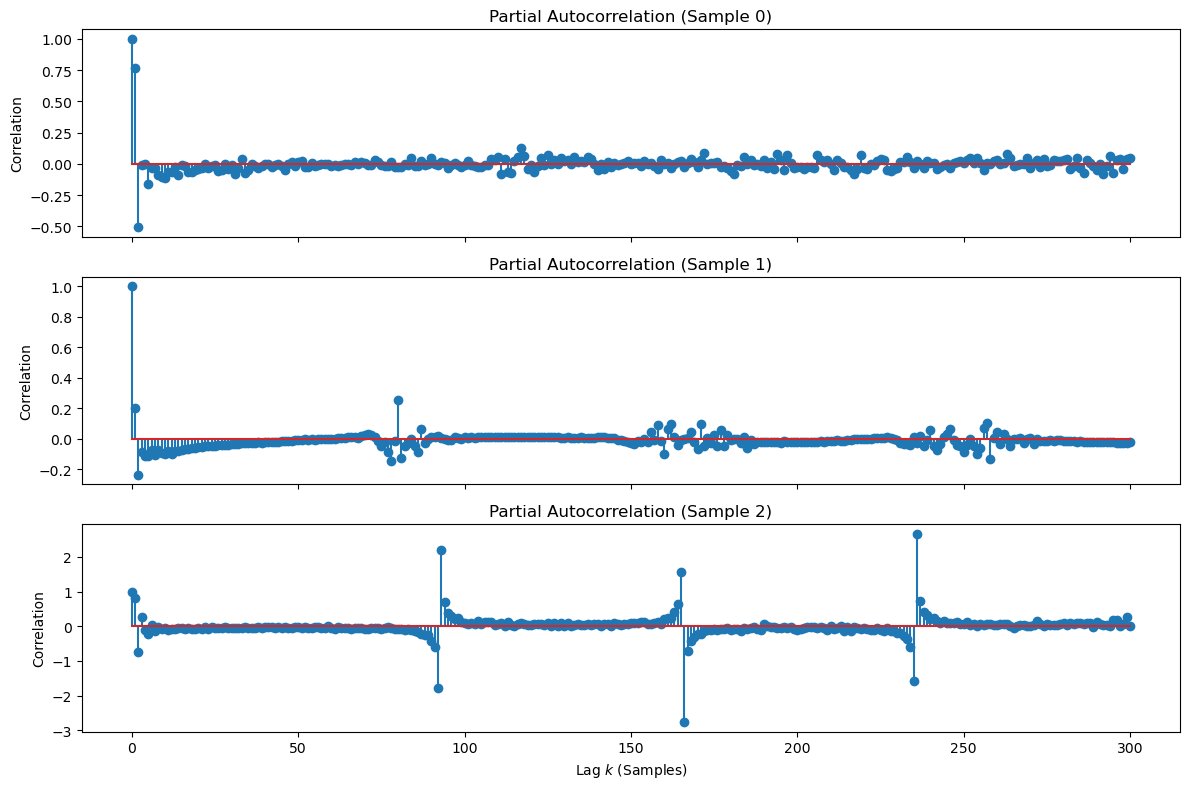

Searching for optimal lag order p using AIC...

Average AIC scores per lag (Lower is better):
Lag 1: -4498.36
Lag 2: -4681.27
Lag 3: -4685.28
Lag 4: -4697.12
Lag 5: -4700.19
Lag 6: -4706.68
Lag 7: -4708.74
Lag 8: -4709.95
Lag 9: -4712.99
Lag 10: -4718.68
Lag 11: -4718.55
Lag 12: -4717.37
Lag 13: -4715.24
Lag 14: -4713.64
Lag 15: -4710.87
Lag 16: -4707.68
Lag 17: -4704.26
Lag 18: -4701.37
Lag 19: -4698.79
Lag 20: -4696.93
Lag 21: -4693.89
Lag 22: -4689.11
Lag 23: -4684.13
Lag 24: -4679.75
Lag 25: -4683.39
Lag 26: -4681.70
Lag 27: -4678.28
Lag 28: -4677.13
Lag 29: -4672.79
Lag 30: -4667.63
Lag 31: -4661.88
Lag 32: -4657.06
Lag 33: -4650.84
Lag 34: -4645.31
Lag 35: -4639.31
Lag 36: -4632.95
Lag 37: -4626.48
Lag 38: -4620.36
Lag 39: -4613.56
Lag 40: -4607.78
Lag 41: -4602.44
Lag 42: -4596.05
Lag 43: -4589.46
Lag 44: -4582.96
Lag 45: -4576.31
Lag 46: -4570.74
Lag 47: -4564.96
Lag 48: -4559.28
Lag 49: -4553.54
Lag 50: -4547.53

Selected Order: p = 10 (covering 20.0 ms)


In [5]:
n_samples_analysis = 3
lags_to_plot = 300

fig, axes = plt.subplots(n_samples_analysis, 1, figsize=(12, 8), sharex=True)

for i in range(n_samples_analysis):
    # Calculate PACF
    # method='yw' (Yule-Walker) is standard for this
    pacf_vals = pacf(X_test_history[i], nlags=lags_to_plot, method='yw')
    
    # Plot
    axes[i].stem(range(len(pacf_vals)), pacf_vals)
    axes[i].set_title(f"Partial Autocorrelation (Sample {i})")
    axes[i].set_ylabel("Correlation")

axes[-1].set_xlabel("Lag $k$ (Samples)")
plt.tight_layout()
plt.show()

print("Searching for optimal lag order p using AIC...")
test_lags = list(range(1, 51))  # Test lags from 1 to 50
aic_scores = {p: [] for p in test_lags}
subset_idx = np.random.choice(len(X_test_history), 50, replace=False) # Test on 50 samples

for idx in subset_idx:
    signal = X_test_history[idx]
    for p in test_lags:
        try:
            model = AutoReg(signal, lags=p, trend='n').fit()
            aic_scores[p].append(model.aic)
        except:
            pass

# Compute average AIC per lag
avg_aic = {p: np.mean(scores) for p, scores in aic_scores.items()}
best_p = min(avg_aic, key=avg_aic.get)

print("\nAverage AIC scores per lag (Lower is better):")
for p, score in avg_aic.items():
    print(f"Lag {p}: {score:.2f}")

print(f"\nSelected Order: p = {best_p} (covering {best_p * DT} ms)")
AR_LAG = best_p

### 3.2. Instance-Specific Prediction

We now proceed to evaluate the model on the test set. For every signal in the test set:

1. We fit an $\text{AR}(p)$ model to the History ($1000$ points) via Ordinary Least Squares.
2. We forecast the Future ($250$ points).
3. We compare the forecast against the Target.

In [6]:
N_EVAL_SAMPLES = 50 # Number of samples to evaluate (set to len(X_test) for full run)
indices_to_evaluate = np.arange(N_EVAL_SAMPLES)
# indices_to_evaluate = np.random.choice(len(X_test_history), N_EVAL_SAMPLES, replace=False)

# Storage
ar_predictions = []
ar_targets = []
ar_mses = []

print(f"Running AR({AR_LAG}) on {N_EVAL_SAMPLES} samples...")

for idx in tqdm.tqdm(indices_to_evaluate):
    history = X_test_history[idx]
    target = X_test_target[idx]
    
    try:
        # 1. Fit Model
        # trend='n' because we already centered the data in Section 2
        model = AutoReg(history, lags=AR_LAG, trend='n', old_names=False).fit()
        
        # 2. Forecast
        # Start predicting from the end of history
        start_idx = len(history)
        end_idx = len(history) + T_PRED - 1
        forecast = model.predict(start=start_idx, end=end_idx, dynamic=False)
        
        # 3. Store
        ar_predictions.append(forecast)
        ar_targets.append(target)
        mse = mean_squared_error(target, forecast)
        # Check for NaN or Inf values
        if not (np.isnan(mse) or np.isinf(mse)):
            ar_mses.append(mse)
        
    except Exception as e:
        print(f"Convergence error at index {idx}: {e}")

# Convert to numpy arrays for vector operations
ar_predictions = np.array(ar_predictions)
ar_targets = np.array(ar_targets)

print(f"\nCompleted. Average MSE: {np.mean(ar_mses):.6f}")

Running AR(10) on 50 samples...


100%|██████████| 50/50 [00:00<00:00, 178.40it/s]


Completed. Average MSE: 0.005450


### 3.3. Evaluation and the Spike Metric

Given the sparse nature of EGMs (mostly isoelectric baselines with sharp activations), global MSE can be misleading. A model predicting a flat line achieves a low MSE but fails clinically.

We introduce Spike Metrics, which evaluate error only when the ground truth signal exceeds the $95$-th percentile of amplitude (i.e., during the heartbeat).

(50,)


50it [00:00, 8328.64it/s]

--- AR(10) Results ---
Global MSE:    0.005450
Spike MSE:     0.079764
Spike MAE:     0.188643


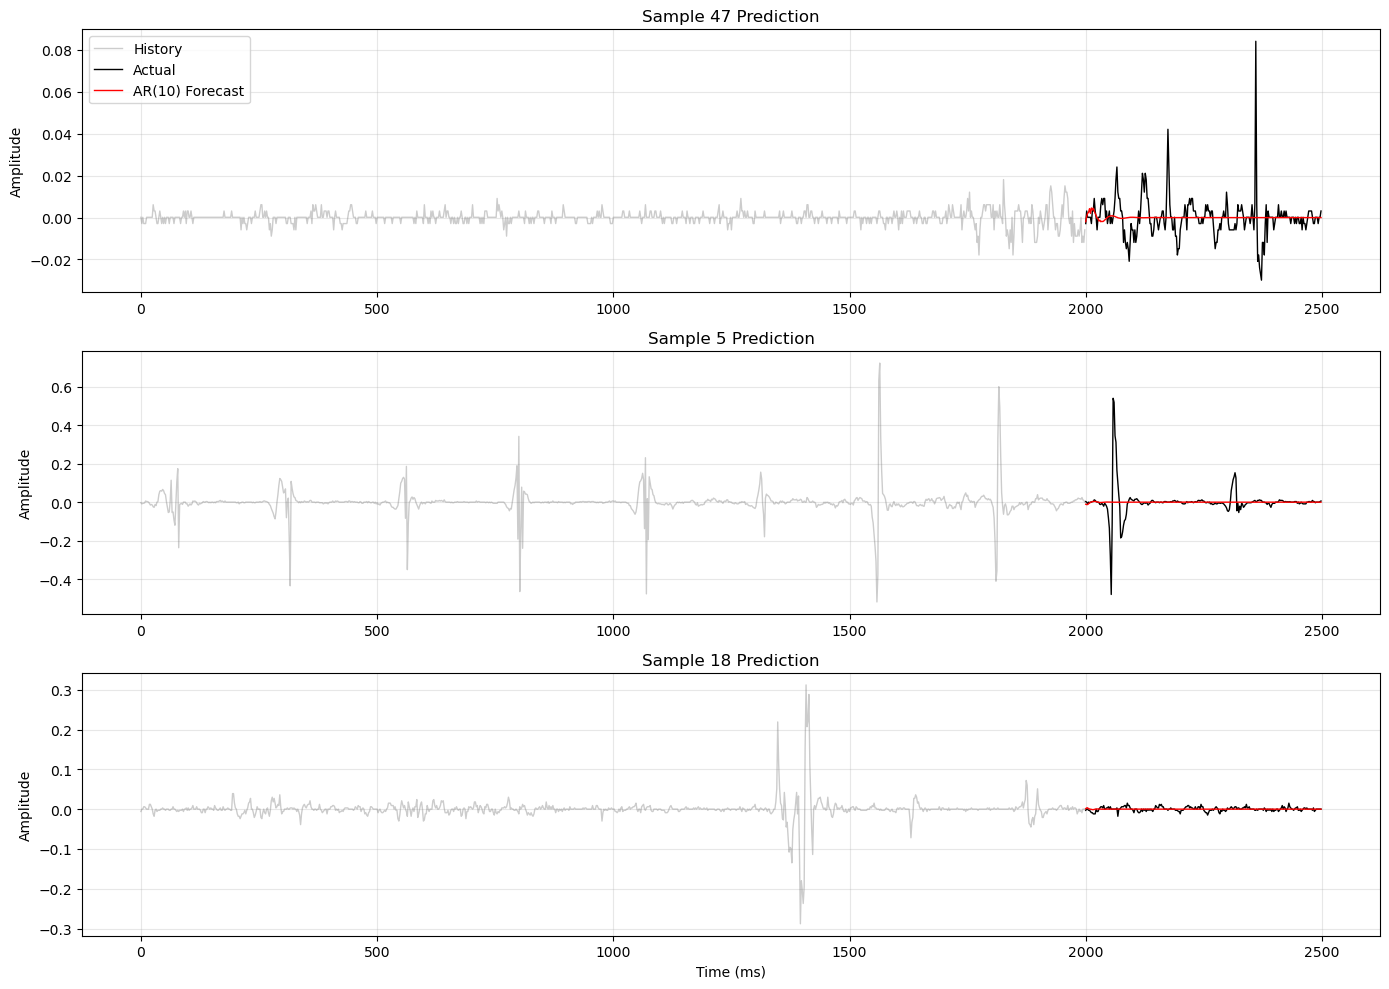

In [7]:
def calculate_metrics(predictions, targets, model_name="AR Model"):
    # 1. Global Metrics
    # Remove any samples with NaN, Inf, or very large values
    inf_or_nan_mask = np.any(np.isinf(predictions) | np.isnan(predictions) | (predictions > 1e6), axis=1)
    print(inf_or_nan_mask.shape)
    predictions = predictions[~inf_or_nan_mask]
    targets = targets[~inf_or_nan_mask]
    
    mse = np.mean((predictions - targets) ** 2)
    
    # 2. Spike Metrics (High Amplitude Regions)
    # Determine threshold per signal or globally? 
    # Here we do it globally for the batch to speed up, or per signal for precision.
    # We will do per-signal to be rigorous.
    
    spike_mses = []
    spike_maes = []
    
    for pred, true in tqdm.tqdm(zip(predictions, targets)):
        # Threshold: 95th percentile of the absolute signal amplitude
        threshold = np.percentile(np.abs(true), 95)
        mask = np.abs(true) > threshold
        
        if np.sum(mask) > 0:
            spike_mses.append(np.mean((pred[mask] - true[mask])**2))
            spike_maes.append(np.mean(np.abs(pred[mask] - true[mask])))
            
    avg_spike_mse = np.mean(spike_mses)
    avg_spike_mae = np.mean(spike_maes)
    
    print(f"--- {model_name} Results ---")
    print(f"Global MSE:    {mse:.6f}")
    print(f"Spike MSE:     {avg_spike_mse:.6f}")
    print(f"Spike MAE:     {avg_spike_mae:.6f}")
    
    return mse, avg_spike_mse

# Run Evaluation
ar_global_mse, ar_spike_mse = calculate_metrics(ar_predictions, ar_targets, f"AR({AR_LAG})")

fig, axes = plt.subplots(3, 1, figsize=(14, 10))
plot_indices = np.random.choice(len(ar_predictions), 3, replace=False)

time_hist = np.arange(0, T_OBS) * DT
time_pred = np.arange(T_OBS, T_OBS + T_PRED) * DT

for i, idx in enumerate(plot_indices):
    ax = axes[i]
    # We need to recover the history for this specific prediction
    # Note: 'indices_to_evaluate' maps local index 'idx' to global X_test index
    global_idx = indices_to_evaluate[idx]
    
    ax.plot(time_hist, X_test_history[global_idx], "gray", linewidth=1, alpha=0.4, label='History')
    ax.plot(time_pred, ar_targets[idx], "k-", linewidth=1, label='Actual')
    ax.plot(time_pred, ar_predictions[idx], "r-", linewidth=1, label=f'AR({AR_LAG}) Forecast')
    
    ax.set_title(f"Sample {global_idx} Prediction")
    ax.set_ylabel("Amplitude")
    if i == 0: ax.legend()
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Time (ms)")
plt.tight_layout()
plt.show()

## 4. $\text{ARMA}(p, q)$ and $\text{ARIMA}(p, d, q)$ Models

In this section, we extend the autoregressive framework by introducing:

1. **Moving Average (MA) terms ($q$)**: Modeling the signal as a function of past errors (shocks).
2. **Integration (d)**: Differencing the data to remove trends (non-stationarity).

The general $\text{ARIMA}(p, d, q)$ equation is:

$$
\left(1 - \sum_{i=1}^{p} \phi_i L^i\right) (1 - L)^d X_t = c + \left(1 + \sum_{j=1}^{q} \theta_j L^j\right) \varepsilon_t.
$$

Note that this form is equivalent to the one presented earlier, just rearranged.

### 4.1. Stationarity Check (Determining $d$)

Before applying ARIMA, we must check if differencing ($d > 0$) is necessary. We use the Augmented Dickey-Fuller (ADF) test. The test's null hypothesis states that the time series has a unit root (non-stationary). If $p-\text{value} < 0.05$, we reject $H_0$​, conclude stationarity, and set $d = 0$.

In [8]:
print("Checking Stationarity on random samples...")
n_checks = 5
stationary_count = 0

sample_indices = np.random.choice(len(X_test_history), n_checks, replace=False)

for i, idx in enumerate(sample_indices):
    result = adfuller(X_test_history[idx])
    p_value = result[1]
    is_stationary = p_value < 0.05
    stationary_count += int(is_stationary)
    
    print(f"Sample {idx}: p-value = {p_value:.6f} -> {'Stationary' if is_stationary else 'Non-Stationary'}")

print(f"\nResult: {stationary_count}/{n_checks} samples are stationary.")
if stationary_count > n_checks / 2:
    print("Conclusion: EGMs are predominantly Stationary. We will set d = 0 (ARMA).")
    ARIMA_d = 0
else:
    print("Conclusion: Unit roots detected. We will set d = 1 (ARIMA).")
    ARIMA_d = 1

Checking Stationarity on random samples...
Sample 9196: p-value = 0.000000 -> Stationary
Sample 10398: p-value = 0.000000 -> Stationary
Sample 9804: p-value = 0.000000 -> Stationary
Sample 11571: p-value = 0.000000 -> Stationary
Sample 1862: p-value = 0.000000 -> Stationary

Result: 5/5 samples are stationary.
Conclusion: EGMs are predominantly Stationary. We will set d = 0 (ARMA).


### 4.2. Instance-Specific Prediction

We evaluate an $\text{ARMA}(p,q)$ model. High-order ARMA is notoriously unstable. We will use small autoregressive and moving average orders (e.g., $p < 50$, $q = 1$ or $2$) to test if modeling "shocks" improves spike prediction.

In [9]:
ARIMA_ORDER = (min(AR_LAG, 50), ARIMA_d, 2)

N_ARIMA_SAMPLES = 50   # Kept small due to training time (approx 1-2 sec per sample)
arima_indices = np.arange(N_ARIMA_SAMPLES)
# arima_indices = np.random.choice(len(X_test_history), N_ARIMA_SAMPLES, replace=False)

arima_predictions = []
arima_targets = []
arima_mses = []

print(f"Running ARIMA{ARIMA_ORDER} on {N_ARIMA_SAMPLES} samples...")

for idx in tqdm.tqdm(arima_indices):
    history = X_test_history[idx]
    target = X_test_target[idx]
    
    try:
        # 1. Define Model
        # enforce_stationarity=False helps convergence on short, volatile windows
        model = ARIMA(history, order=ARIMA_ORDER, trend='n', enforce_stationarity=False)
        
        # 2. Fit (Iterative MLE)
        model_fit = model.fit(method_kwargs={'maxiter': 200, 'disp': 0})
        
        # 3. Forecast
        forecast = model_fit.forecast(steps=T_PRED)
        
        arima_predictions.append(forecast)
        arima_targets.append(target)
        mse = mean_squared_error(target, forecast)
        # Check for NaN or Inf values
        if not (np.isnan(mse) or np.isinf(mse)):
            arima_mses.append(mse)
        
    except Exception as e:
        # Fallback or Skip
        print(f"Sample {idx} Failed: {e}")

arima_predictions = np.array(arima_predictions)
arima_targets = np.array(arima_targets)

print(f"\nCompleted. Average ARIMA MSE: {np.mean(arima_mses):.6f}")

# Evaluate Spike Metrics for ARIMA
# Reuse function from Section 3
arima_global_mse, arima_spike_mse = calculate_metrics(arima_predictions, arima_targets, f"ARIMA{ARIMA_ORDER}")

Running ARIMA(10, 0, 2) on 50 samples...


  0%|          | 0/50 [00:00<?, ?it/s]c:\Users\javat\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  4%|▍         | 2/50 [00:11<04:01,  5.04s/it]c:\Users\javat\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 10%|█         | 5/50 [00:28<04:08,  5.52s/it]c:\Users\javat\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 12%|█▏        | 6/50 [00:36<04:41,  6.40s/it]c:\Users\javat\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

Sample 38 Failed: Input contains NaN.


c:\Users\javat\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 80%|████████  | 40/50 [03:31<00:44,  4.49s/it]c:\Users\javat\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 82%|████████▏ | 41/50 [03:38<00:46,  5.20s/it]c:\Users\javat\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 86%|████████▌ | 43/50 [03:51<00:40,  5.76s/it]c:\Users\javat\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Max


Completed. Average ARIMA MSE: 0.005530
(50,)


49it [00:00, 10878.15it/s]

--- ARIMA(10, 0, 2) Results ---
Global MSE:    0.005530
Spike MSE:     0.081284
Spike MAE:     0.191657


We visualize whether the added complexity of the Moving Average term provided better tracking of the signal peaks compared to the simpler AR model.

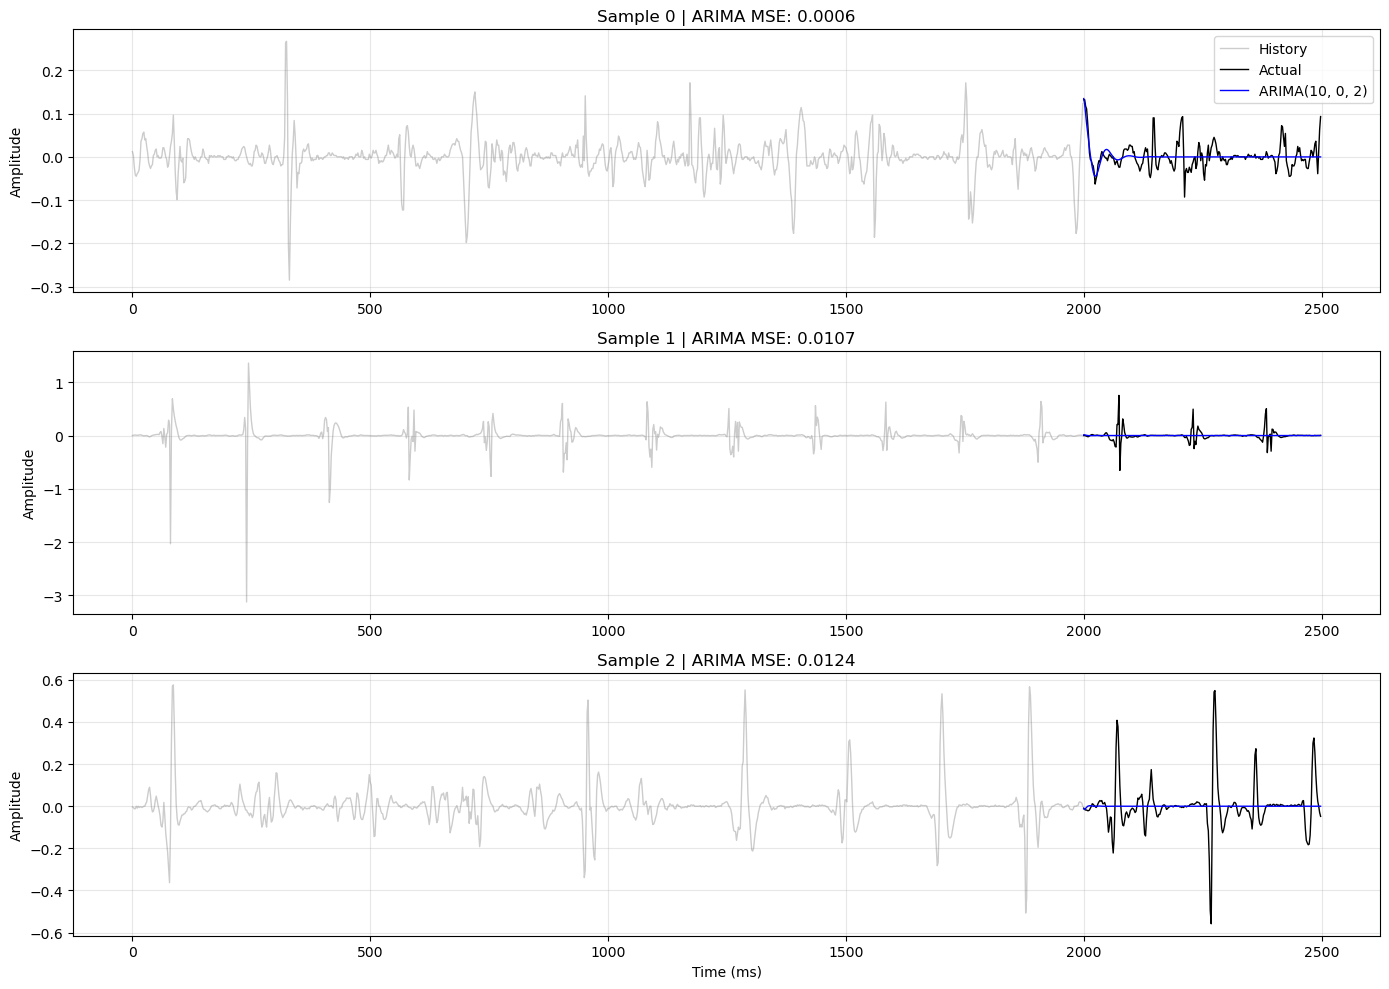

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10))
# Plot the first 3 successful ARIMA predictions
plot_count = min(3, len(arima_predictions))

time_hist = np.arange(0, T_OBS) * DT
time_pred = np.arange(T_OBS, T_OBS + T_PRED) * DT

for i in range(plot_count):
    ax = axes[i]
    
    # Identify the global index to fetch history
    global_idx = arima_indices[i]
    
    # Plot History
    ax.plot(time_hist, X_test_history[global_idx], 'gray', linewidth=1, alpha=0.4, label='History')
    
    # Plot Target
    ax.plot(time_pred, arima_targets[i], 'k-', linewidth=1, label='Actual')
    
    # Plot ARIMA Forecast
    ax.plot(time_pred, arima_predictions[i], 'b-', linewidth=1, label=f'ARIMA{ARIMA_ORDER}')
    
    # Optional: If we had AR predictions for these specific indices, we could overlay them.
    # But since indices are random, we focus on the ARIMA performance here.
    
    ax.set_title(f"Sample {global_idx} | ARIMA MSE: {arima_mses[i]:.4f}")
    ax.set_ylabel("Amplitude")
    if i == 0: ax.legend()
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Time (ms)")
plt.tight_layout()
plt.show()

Clearly, the results are not that much better than AR alone, suggesting that the added complexity may not be justified for this specific prediction task.

## 5. Time-Varying Autoregressive Models (TVAR)

Standard AR models assume the tissue properties (coefficients $\boldsymbol{\phi}$) are constant over the observation window. However, during arrhythmias, the heart rate and conduction velocity often change rapidly (non-stationarity). A TVAR model allows the coefficients to evolve over time:

$$
X_t = c(t) + \sum_{i=1}^{p} \phi_i(t) X_{t-i} + \varepsilon_t.
$$

To estimate the trajectory of $\phi_i(t)$​, we use Recursive Least Squares (RLS) via the Kalman Filter. This gives more weight to the most recent data points, allowing the model to capture the "instantaneous" physics of the tissue right before the prediction window starts.

### 5.1. RLS Implementation

We utilize `statsmodels.tsa.recursive.RecursiveLS`. Unlike the standard `AutoReg`, we must manually construct the matrix of regressors (lagged values) for the RLS solver.

In [12]:
TVAR_LAG = min(AR_LAG, 50)
N_TVAR_SAMPLES = 50
tvar_indices = np.arange(N_TVAR_SAMPLES)
#tvar_indices = np.random.choice(len(X_test_history), N_TVAR_SAMPLES, replace=False)

tvar_predictions = []
tvar_targets = []
tvar_mses = []

print(f"Running TVAR (RLS) on {N_TVAR_SAMPLES} samples...")

for idx in tqdm.tqdm(tvar_indices):
    history = X_test_history[idx]
    target = X_test_target[idx]
    
    try:
        # 1. Construct Exogenous Matrix (Regressors)
        # For RLS, we need a matrix where row 't' contains [X_{t-1}, ..., X_{t-p}]
        # We construct this manually.
        
        # Create Lagged Matrix
        X_mat = []
        y_vec = []
        
        # We lose the first 'TVAR_LAG' points for initialization
        for t in range(TVAR_LAG, len(history)):
            lagged_vals = history[t - TVAR_LAG : t][::-1] # Reverse to get t-1, t-2...
            X_mat.append(lagged_vals)
            y_vec.append(history[t])
            
        X_mat = np.array(X_mat)
        y_vec = np.array(y_vec)
        
        # 2. Define and Fit RLS Model
        # This runs the Kalman Filter through the history to track parameter evolution
        model = RecursiveLS(y_vec, X_mat)
        res = model.fit()
        
        # 3. Forecast
        # RLS gives us the parameters at the *last* step of history: res.params[-1]
        # We use these "most recent" coefficients to project into the future.
        # (Assumption: Tissue properties remain stable for the next 0.5s)
        
        last_coeffs = res.recursive_coefficients.filtered[:, -1]
        
        # Iterative Prediction Loop
        current_history = list(history) # Start with full history
        pred_steps = []
        
        for _ in range(T_PRED):
            # Get last 'p' values
            # Note: Must match the order we built X_mat (t-1, t-2...)
            lags = np.array(current_history[-TVAR_LAG:][::-1])
            
            # Dot product
            next_val = np.dot(last_coeffs, lags)
            
            pred_steps.append(next_val)
            current_history.append(next_val)
            
        tvar_predictions.append(pred_steps)
        tvar_targets.append(target)
        tvar_mses.append(mean_squared_error(target, pred_steps))
        
    except Exception as e:
        print(f"TVAR Error sample {idx}: {e}")

tvar_predictions = np.array(tvar_predictions)
tvar_targets = np.array(tvar_targets)

print(f"\nCompleted. Average TVAR MSE: {np.mean(tvar_mses):.6f}")

# Metrics
tvar_global_mse, tvar_spike_mse = calculate_metrics(tvar_predictions, tvar_targets, "TVAR (RLS)")

Running TVAR (RLS) on 50 samples...


100%|██████████| 50/50 [00:01<00:00, 27.52it/s]



Completed. Average TVAR MSE: 0.005450
(50,)


50it [00:00, 12496.44it/s]

--- TVAR (RLS) Results ---
Global MSE:    0.005450
Spike MSE:     0.079764
Spike MAE:     0.188643


### 5.2. Coefficient Evolution Analysis

One of the main advantages of TVAR is interpretability. We can visualize how the model changed its mind about the "physics" of the signal over the 2-second history.

If the coefficients are flat lines, the signal was stationary. If they wiggle or jump, the tissue properties were changing.

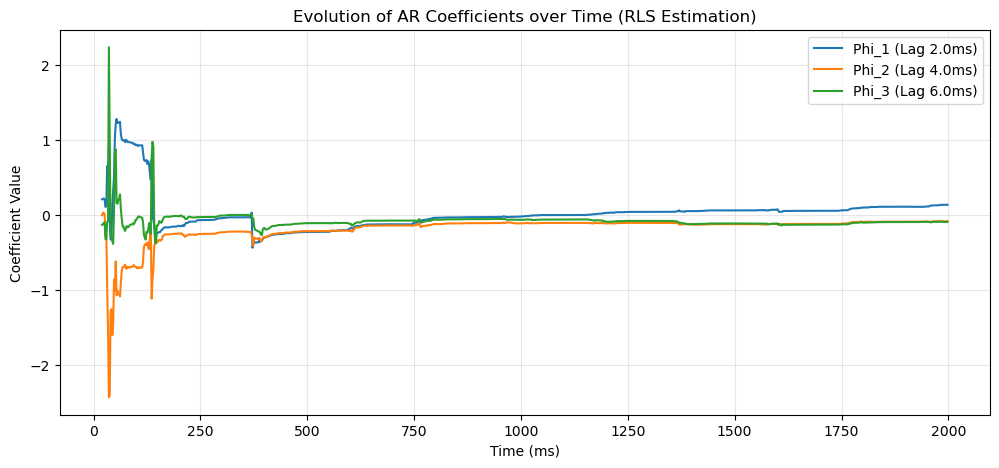

In [14]:
# Visualize the evolution of the first 3 coefficients for the last processed sample
fig, ax = plt.subplots(figsize=(12, 5))

# res is from the last loop iteration
coefficients = res.recursive_coefficients.filtered.T  # Shape: (Time, Coefficients)
time_axis = np.arange(TVAR_LAG, len(history)) * DT

# Plot only first 3 coefficients for clarity
ax.plot(time_axis, coefficients[:, 0], label=f"Phi_1 (Lag {DT}ms)")
ax.plot(time_axis, coefficients[:, 1], label=f"Phi_2 (Lag {DT*2}ms)")
ax.plot(time_axis, coefficients[:, 2], label=f"Phi_3 (Lag {DT*3}ms)")

ax.set_title("Evolution of AR Coefficients over Time (RLS Estimation)")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Coefficient Value")
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

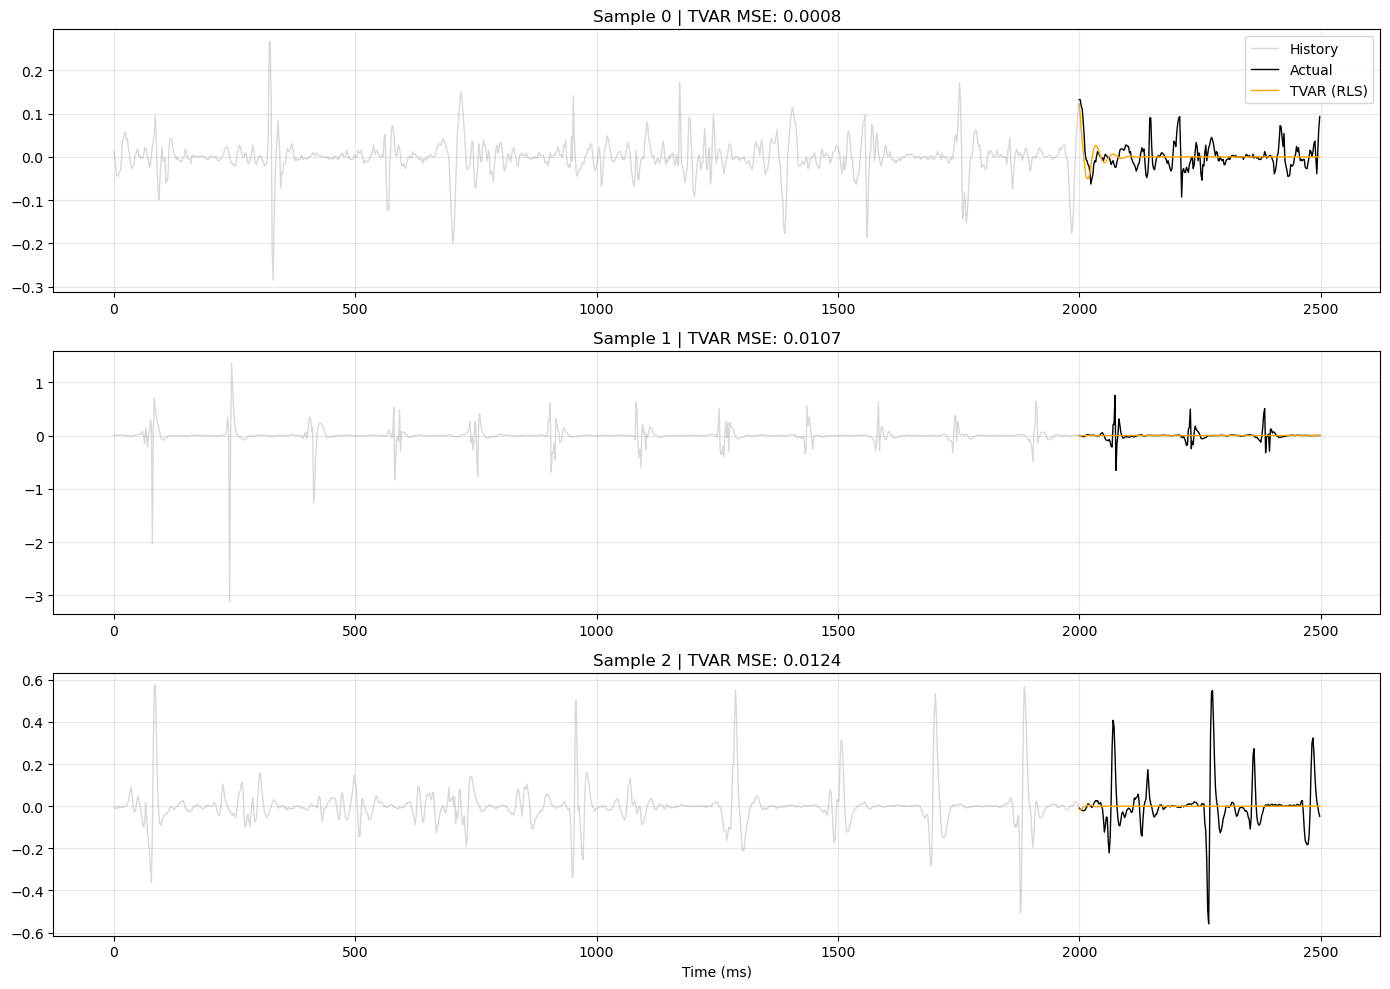

In [15]:
fig, axes = plt.subplots(min(3, len(tvar_predictions)), 1, figsize=(14, 10))

for i in range(len(axes)):
    ax = axes[i]
    
    # Global index
    global_idx = tvar_indices[i]
    
    # Plot History
    ax.plot(np.arange(0, T_OBS)*DT, X_test_history[global_idx], "gray", linewidth=1, alpha=0.3, label="History")
    
    # Plot Target
    time_pred = np.arange(T_OBS, T_OBS + T_PRED) * DT
    ax.plot(time_pred, tvar_targets[i], "k-", linewidth=1, label="Actual")
    
    # Plot TVAR
    ax.plot(time_pred, tvar_predictions[i], "orange", linestyle='-', linewidth=1, label="TVAR (RLS)")

    ax.set_title(f"Sample {global_idx} | TVAR MSE: {tvar_mses[i]:.4f}")
    ax.grid(True, alpha=0.3)
    if i==0: ax.legend()

axes[-1].set_xlabel("Time (ms)")
plt.tight_layout()
plt.show()

## 6. Final Model Comparison

We now aggregate the results from all autoregressive architectures tested.

In [16]:
results_data = []

# 1. AR Results
if "ar_global_mse" in locals():
    results_data.append({
        "Model": f"AR({AR_LAG})",
        "Type": "Linear / Static",
        "Global MSE": ar_global_mse,
        "Spike MSE": ar_spike_mse
    })

# 2. ARIMA Results
if "arima_global_mse" in locals():
    results_data.append({
        "Model": f"ARIMA{ARIMA_ORDER}",
        "Type": "Iterative / MA",
        "Global MSE": arima_global_mse,
        "Spike MSE": arima_spike_mse
    })

# 3. TVAR Results
if "tvar_global_mse" in locals():
    results_data.append({
        "Model": f"TVAR (Lag {TVAR_LAG})",
        "Type": "Time-Varying (RLS)",
        "Global MSE": tvar_global_mse,
        "Spike MSE": tvar_spike_mse
    })

# Create DataFrame
results_df = pd.DataFrame(results_data)
results_df = results_df.set_index("Model")

print("="*60)
print("FINAL PERFORMANCE SUMMARY")
print("="*60)
print(results_df.sort_values(by="Spike MSE"))

FINAL PERFORMANCE SUMMARY
                               Type  Global MSE  Spike MSE
Model                                                     
TVAR (Lag 10)    Time-Varying (RLS)     0.00545   0.079764
AR(10)              Linear / Static     0.00545   0.079764
ARIMA(10, 0, 2)      Iterative / MA     0.00553   0.081284


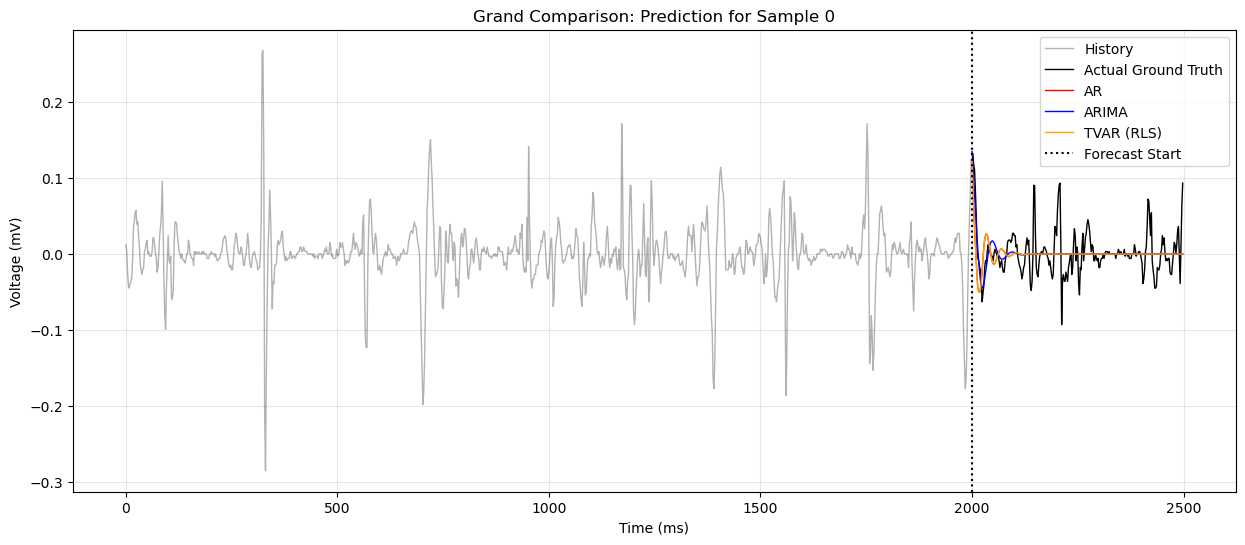

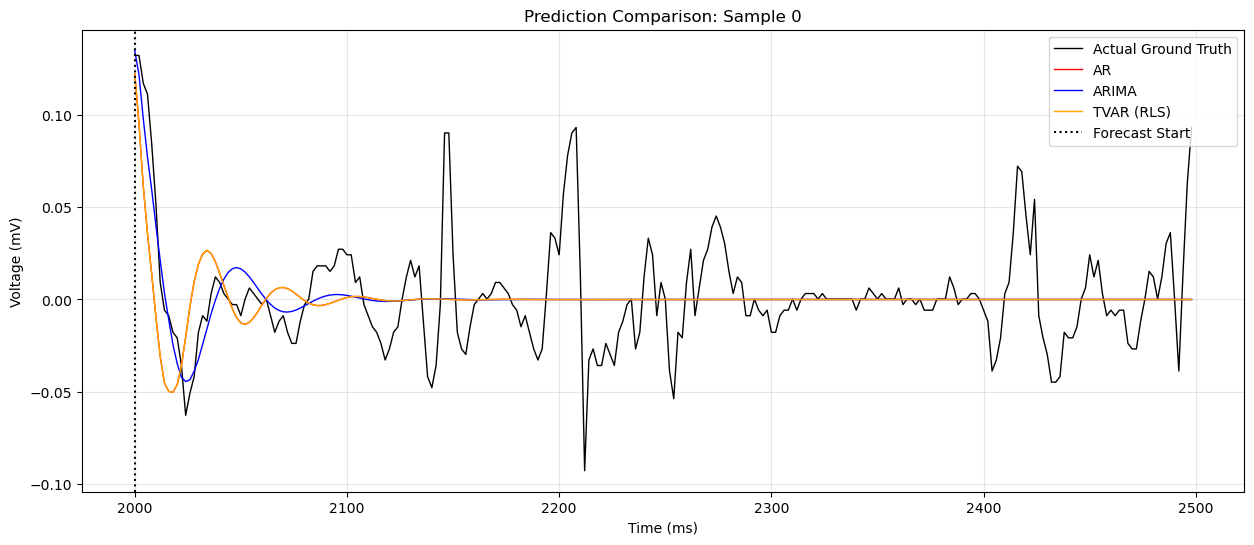

In [17]:
sample_idx = 0 # np.random.randint(0, len(X_test_history))
history = X_test_history[sample_idx]
target = X_test_target[sample_idx]

plt.figure(figsize=(15, 6))

# Plot History & Target
plt.plot(time_hist, history, 'k', linewidth=1, alpha=0.3, label="History")
plt.plot(time_pred, target, 'k', linewidth=1, label="Actual Ground Truth")

plt.plot(time_pred, ar_predictions[sample_idx], "r-", linewidth=1, label="AR")
plt.plot(time_pred, arima_predictions[sample_idx], "b-", linewidth=1, label="ARIMA")
plt.plot(time_pred, tvar_predictions[sample_idx], "orange", linestyle='-', linewidth=1, label="TVAR (RLS)")

plt.title(f"Grand Comparison: Prediction for Sample {sample_idx}")
plt.axvline(x=T_OBS*DT, color='k', linestyle=':', label="Forecast Start")
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.grid(True, alpha=0.3)
plt.show()

# Plot only prediction region
plt.figure(figsize=(15, 6))
plt.plot(time_pred, target, 'k', linewidth=1, label='Actual Ground Truth')

plt.plot(time_pred, ar_predictions[sample_idx], "r-", linewidth=1, label="AR")
plt.plot(time_pred, arima_predictions[sample_idx], "b-", linewidth=1, label="ARIMA")
plt.plot(time_pred, tvar_predictions[sample_idx], "orange", linestyle='-', linewidth=1, label="TVAR (RLS)")

plt.title(f"Prediction Comparison: Sample {sample_idx}")
plt.axvline(x=T_OBS*DT, color='k', linestyle=':', label="Forecast Start")
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.grid(True, alpha=0.3)
plt.show()  

## 7. Conclusions

Overall, the AR family of models achieve good metrics for EGM signal prediction, but when we actually look at the spike predictions, the performance is terrible, only catching very dampened versions of the spikes up to around 100 ms into the prediction horizon. Beyond that, the models revert to predicting flat lines. So, they are not useful for this task.

## 8. Anomaly Detection: Identifying Arrhythmic Drivers

Although the AR models struggle to produce accurate spike predictions, we can still assume that **signals that are harder to predict are likely chaotic/arrhythmic drivers**.

Our hypothesis:
- **Low Prediction Error** → Organized, predictable tissue (passively activated, healthy)
- **High Prediction Error** → Complex Fractionated Atrial Electrograms (CFAEs), potential ablation targets

We use **Normalized MSE (NMSE)** to rank electrodes by "unpredictability" rather than raw amplitude:

$$\text{NMSE} = \frac{\text{MSE}}{\text{Var}(y_{\text{target}})}$$

This ensures we rank by how *chaotic* the signal is, not how *loud* it is.

In [42]:
# ANOMALY DETECTION USING AR PREDICTION ERROR

# We will run AR on the FULL test set and compute NMSE for each electrode
N_ANOMALY_SAMPLES = len(X_test_history)  # Use all test samples

anomaly_results = []

print(f"Running AR({AR_LAG}) anomaly detection on {N_ANOMALY_SAMPLES} electrodes...")

for idx in tqdm.tqdm(range(N_ANOMALY_SAMPLES)):
    history = X_test_history[idx]
    target = X_test_target[idx]
    
    # Get patient metadata for this electrode
    patient_info = test_metadata.iloc[idx]
    
    try:
        # Fit AR model on history
        model = AutoReg(history, lags=AR_LAG, trend='n', old_names=False).fit()
        
        # Forecast
        forecast = model.predict(start=len(history), end=len(history) + T_PRED - 1)
        
        # Calculate MSE
        mse = mean_squared_error(target, forecast)
        
        # Calculate Signal Energy (Variance) for normalization
        signal_variance = np.var(target)
        if signal_variance < 1e-10:
            signal_variance = 1e-10  # Avoid division by zero
        
        # Normalized MSE (NMSE)
        # NMSE > 1 means model is worse than predicting the mean
        nmse = mse / signal_variance
        
        # Store results with patient metadata
        anomaly_results.append({
            'index': idx,
            'patient_date': patient_info['patient_date'],
            'map_name': patient_info['map_name'],
            'electrode_idx_in_patient': patient_info['electrode_idx_in_patient'],
            'mse': mse,
            'nmse': nmse,
            'variance': signal_variance,
            'history': history,
            'target': target,
            'forecast': forecast
        })
        
    except Exception as e:
        print(f"Error at index {idx}: {e}")

# Convert to DataFrame
anomaly_df = pd.DataFrame(anomaly_results)

print(f"\nCompleted anomaly detection on {len(anomaly_df)} electrodes.")
print("\nBreakdown by Patient:")
print(anomaly_df.groupby('patient_date')['nmse'].agg(['count', 'mean', 'std']).round(4))

Running AR(10) anomaly detection on 15954 electrodes...


100%|██████████| 15954/15954 [01:48<00:00, 147.71it/s]


Completed anomaly detection on 15954 electrodes.

Breakdown by Patient:
              count          mean           std
patient_date                                   
2021_09_30     2140  9.977000e-01  1.020000e-01
2021_10_04      402  1.005600e+00  8.730000e-02
2021_10_05      794  1.000600e+00  6.850000e-02
2021_10_18      737  2.360580e+21  6.408442e+22
2021_10_19      754  1.002100e+00  6.914000e-01
2021_11_02     1791  9.988000e-01  9.480000e-02
2021_11_08     1256  1.033600e+00  7.767000e-01
2021_11_10     1299  9.981000e-01  1.384000e-01
2021_11_12     2801  9.975000e-01  8.320000e-02
2021_11_15     1842  9.934000e-01  6.650000e-02
2021_11_16      957  1.616950e+01  4.694702e+02
2021_11_17     1181  1.005000e+00  5.139000e-01


In [43]:
# RANK ELECTRODES BY UNPREDICTABILITY (NMSE)

# Sort by NMSE (descending), most chaotic/unpredictable first
ranked_df = anomaly_df.sort_values('nmse', ascending=False).reset_index(drop=True)

print("=" * 80)
print("ELECTRODE RANKING BY UNPREDICTABILITY (NMSE)")
print("=" * 80)

print("\nTOP 10 MOST UNPREDICTABLE (Potential Arrhythmic Drivers):")
print("-" * 80)
print(ranked_df[['index', 'patient_date', 'map_name', 'electrode_idx_in_patient', 'nmse', 'mse']].head(10).to_string(index=False))

print("\nTOP 10 MOST PREDICTABLE (Healthy / Passively Activated Tissue):")
print("-" * 80)
print(ranked_df[['index', 'patient_date', 'map_name', 'electrode_idx_in_patient', 'nmse', 'mse']].tail(10).to_string(index=False))

# Summary Statistics
print("\n" + "=" * 80)
print("NMSE DISTRIBUTION STATISTICS")
print("=" * 80)
print(f"Mean NMSE:   {anomaly_df['nmse'].mean():.4f}")
print(f"Median NMSE: {anomaly_df['nmse'].median():.4f}")
print(f"Std NMSE:    {anomaly_df['nmse'].std():.4f}")
print(f"Min NMSE:    {anomaly_df['nmse'].min():.4f}")
print(f"Max NMSE:    {anomaly_df['nmse'].max():.4f}")

ELECTRODE RANKING BY UNPREDICTABILITY (NMSE)

TOP 10 MOST UNPREDICTABLE (Potential Arrhythmic Drivers):
--------------------------------------------------------------------------------
 index patient_date      map_name  electrode_idx_in_patient         nmse          mse
 10141   2021_10_18      1-1-1-FA                      3741 1.739747e+24 3.017862e+21
  4356   2021_10_18      1-1-1-FA                      1745 4.713825e+15 4.998592e+13
  1361   2021_11_16     1-AI VOLT                      4130 1.452425e+04 7.583102e-01
 10721   2021_10_19          1-AI                         0 1.954983e+01 4.508929e-02
  2109   2021_11_17 1-AI BASAL FA                       244 1.827791e+01 2.353353e-03
  6203   2021_11_08          1-AI                       445 1.804228e+01 3.246597e-04
  5559   2021_11_08          1-AI                      4517 1.760821e+01 1.038297e-01
  9193   2021_10_18      1-1-1-FA                       409 1.444489e+01 8.932004e-05
  3282   2021_11_08          1-AI        

Removed 3 extreme outliers. Remaining: 15951 electrodes.



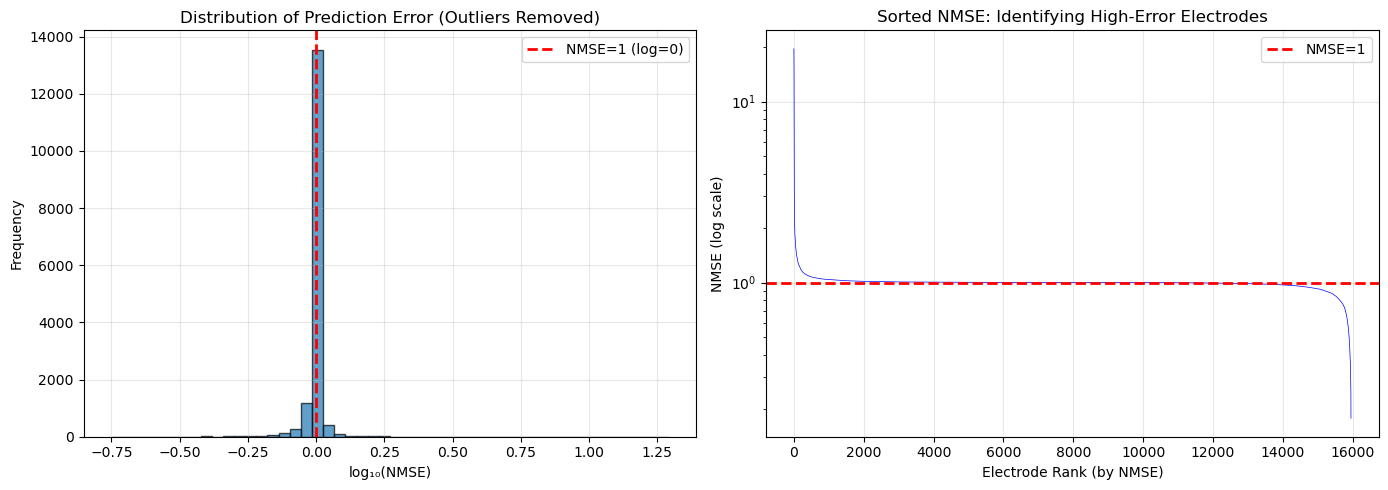

NMSE DISTRIBUTION STATISTICS (Outliers Removed)
Mean NMSE:       1.0021
Median NMSE:     1.0001
Std NMSE:        0.3332
25th Percentile: 0.9938
75th Percentile: 1.0039
90th Percentile: 1.0214
95th Percentile: 1.0472
Min NMSE:        0.1779
Max NMSE:        19.5498

Electrodes with NMSE > 1: 8651 / 15951 (54.2%)

----------------------------------------------------------------------
REMOVED OUTLIERS (Likely AR Numerical Instability):
----------------------------------------------------------------------
 index patient_date  map_name         nmse          mse
  1361   2021_11_16 1-AI VOLT 1.452425e+04 7.583102e-01
  4356   2021_10_18  1-1-1-FA 4.713825e+15 4.998592e+13
 10141   2021_10_18  1-1-1-FA 1.739747e+24 3.017862e+21


In [47]:
# VISUALIZE NMSE DISTRIBUTION (Excluding Extreme Outliers, Log Scale)

# Filter out the 3 extreme outliers (likely numerical instability in AR fit)
outlier_indices = [10141, 4356, 1361]
clean_df = anomaly_df[~anomaly_df['index'].isin(outlier_indices)].copy()

print(f"Removed {len(outlier_indices)} extreme outliers. Remaining: {len(clean_df)} electrodes.\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of log(NMSE)
log_nmse = np.log10(clean_df['nmse'].clip(lower=1e-10))

ax1 = axes[0]
ax1.hist(log_nmse, bins=50, edgecolor='black', alpha=0.7)
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='NMSE=1 (log=0)')
ax1.set_xlabel('log₁₀(NMSE)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Prediction Error (Outliers Removed)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Sorted NMSE plot with log scale
ax2 = axes[1]
sorted_nmse = clean_df['nmse'].sort_values(ascending=False).values
ax2.semilogy(sorted_nmse, 'b-', linewidth=0.5)
ax2.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='NMSE=1')
ax2.set_xlabel('Electrode Rank (by NMSE)')
ax2.set_ylabel('NMSE (log scale)')
ax2.set_title('Sorted NMSE: Identifying High-Error Electrodes')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics on cleaned data
print("=" * 70)
print("NMSE DISTRIBUTION STATISTICS (Outliers Removed)")
print("=" * 70)
print(f"Mean NMSE:       {clean_df['nmse'].mean():.4f}")
print(f"Median NMSE:     {clean_df['nmse'].median():.4f}")
print(f"Std NMSE:        {clean_df['nmse'].std():.4f}")
print(f"25th Percentile: {clean_df['nmse'].quantile(0.25):.4f}")
print(f"75th Percentile: {clean_df['nmse'].quantile(0.75):.4f}")
print(f"90th Percentile: {clean_df['nmse'].quantile(0.90):.4f}")
print(f"95th Percentile: {clean_df['nmse'].quantile(0.95):.4f}")
print(f"Min NMSE:        {clean_df['nmse'].min():.4f}")
print(f"Max NMSE:        {clean_df['nmse'].max():.4f}")

# Count categories
unpredictable_count = (clean_df['nmse'] > 1).sum()
print(f"\nElectrodes with NMSE > 1: {unpredictable_count} / {len(clean_df)} ({100*unpredictable_count/len(clean_df):.1f}%)")

# Show the removed outliers
print("\n" + "-" * 70)
print("REMOVED OUTLIERS (Likely AR Numerical Instability):")
print("-" * 70)
print(anomaly_df[anomaly_df['index'].isin(outlier_indices)][['index', 'patient_date', 'map_name', 'nmse', 'mse']].to_string(index=False))

For most electrodes, the AR model remains close to the baseline ($\mathrm{NMSE} \approx 1$), indicating that the EGM signals are generally too random or non-linear to be accurately predicted over a 0.5\,s horizon using a simple linear model. However, a clear high-error tail appears, reaching up to $\mathrm{NMSE} \approx 20$, which identifies \textbf{anomaly candidates}. These signals are significantly more unpredictable than the rest and are often associated with Complex Fractionated Atrial Electrograms (CFAEs) or chaotic rotor activity that sustains arrhythmias.

In contrast, the low-error tail ($\mathrm{NMSE} < 1$) highlights more organized, healthy tissue, where regular rhythmic patterns allow for better predictability. After removing three extreme numerical artifacts, the remaining NMSE scale is physically meaningful and suitable for ranking the degree of electrical chaos across the tissue.

### 8.1. Visual Validation: High Error vs Low Error Signals

Now we visually inspect the top-K highest and lowest error signals to validate our hypothesis:

- **High Error (Top-K)**: Should appear as Complex Fractionated Atrial Electrograms (CFAEs). Messy, continuous activity without clear isoelectric baselines.
- **Low Error (Bottom-K)**: Should appear as organized, discrete spikes with clear baselines.

HIGH NMSE SIGNALS - Most Unpredictable (Potential Arrhythmic Drivers)


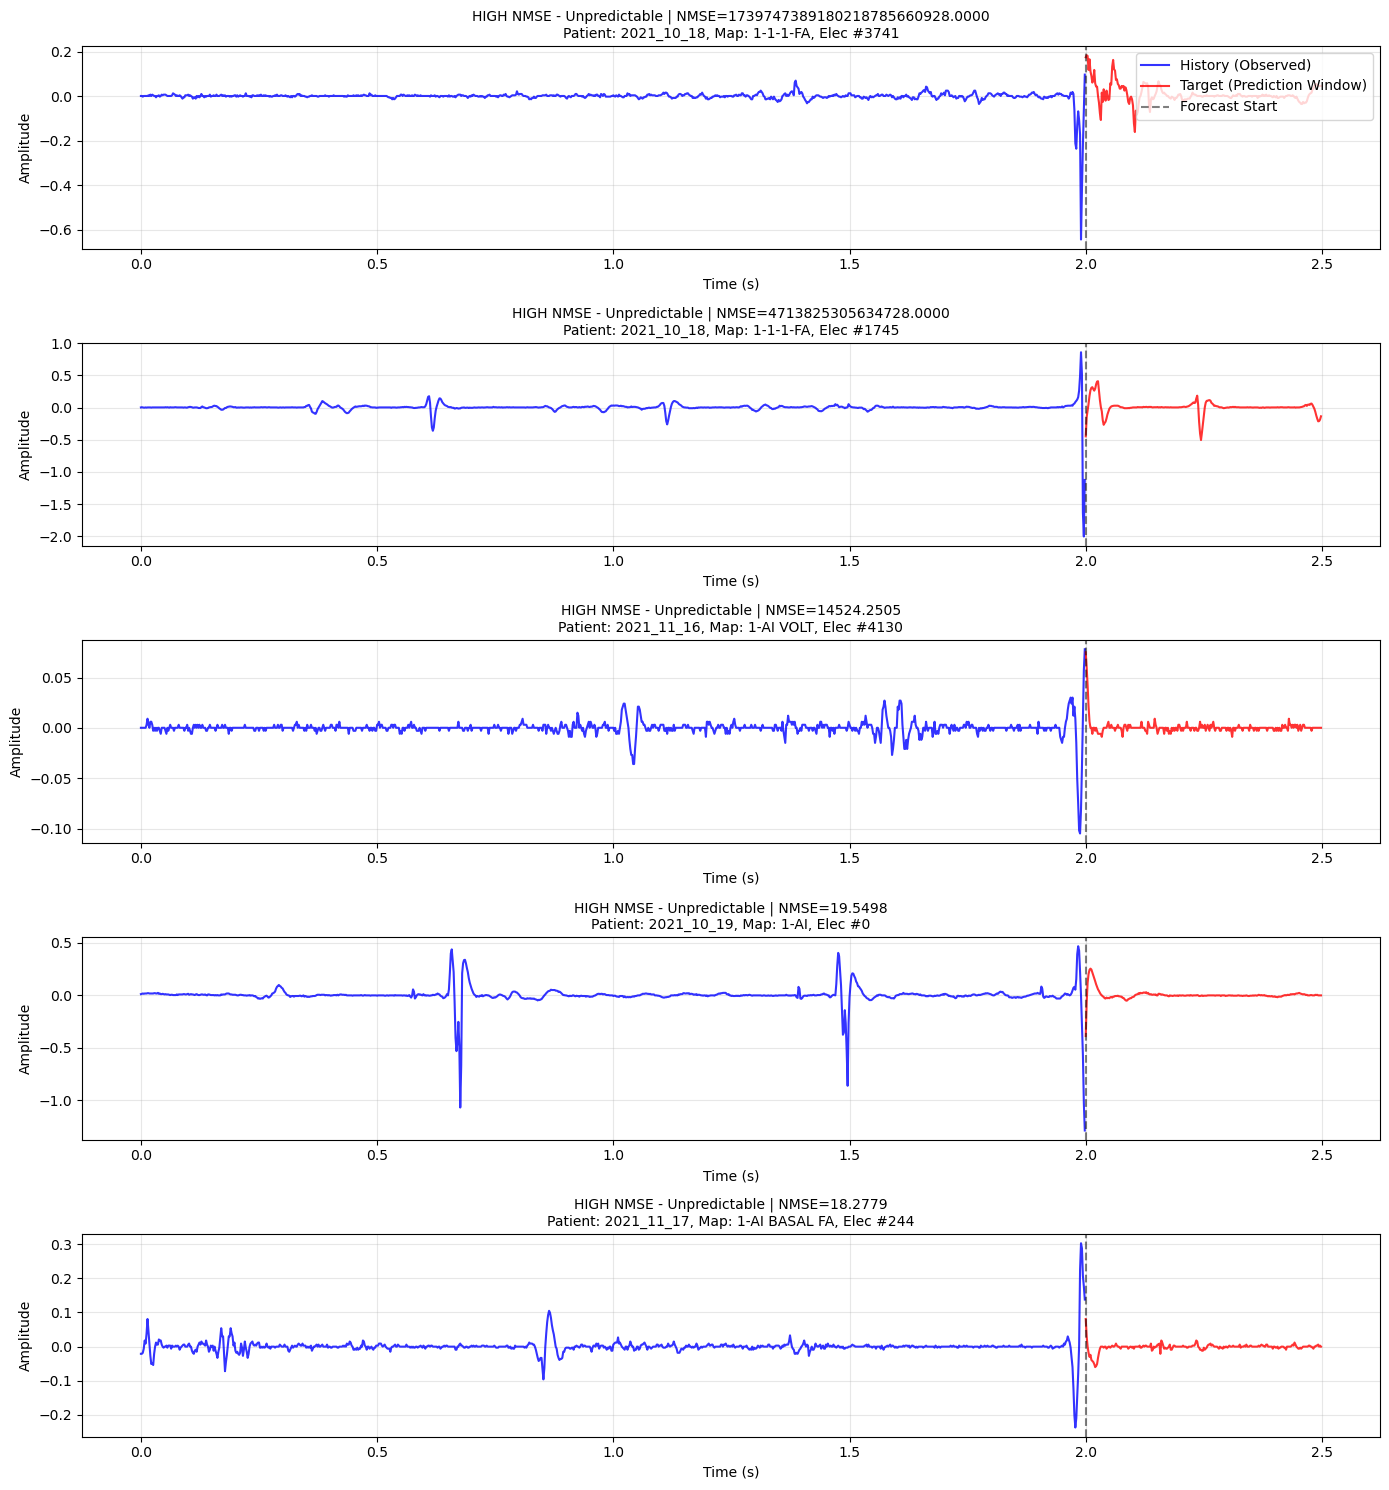


LOW NMSE SIGNALS - Most Predictable (Healthy/Passively Activated Tissue)


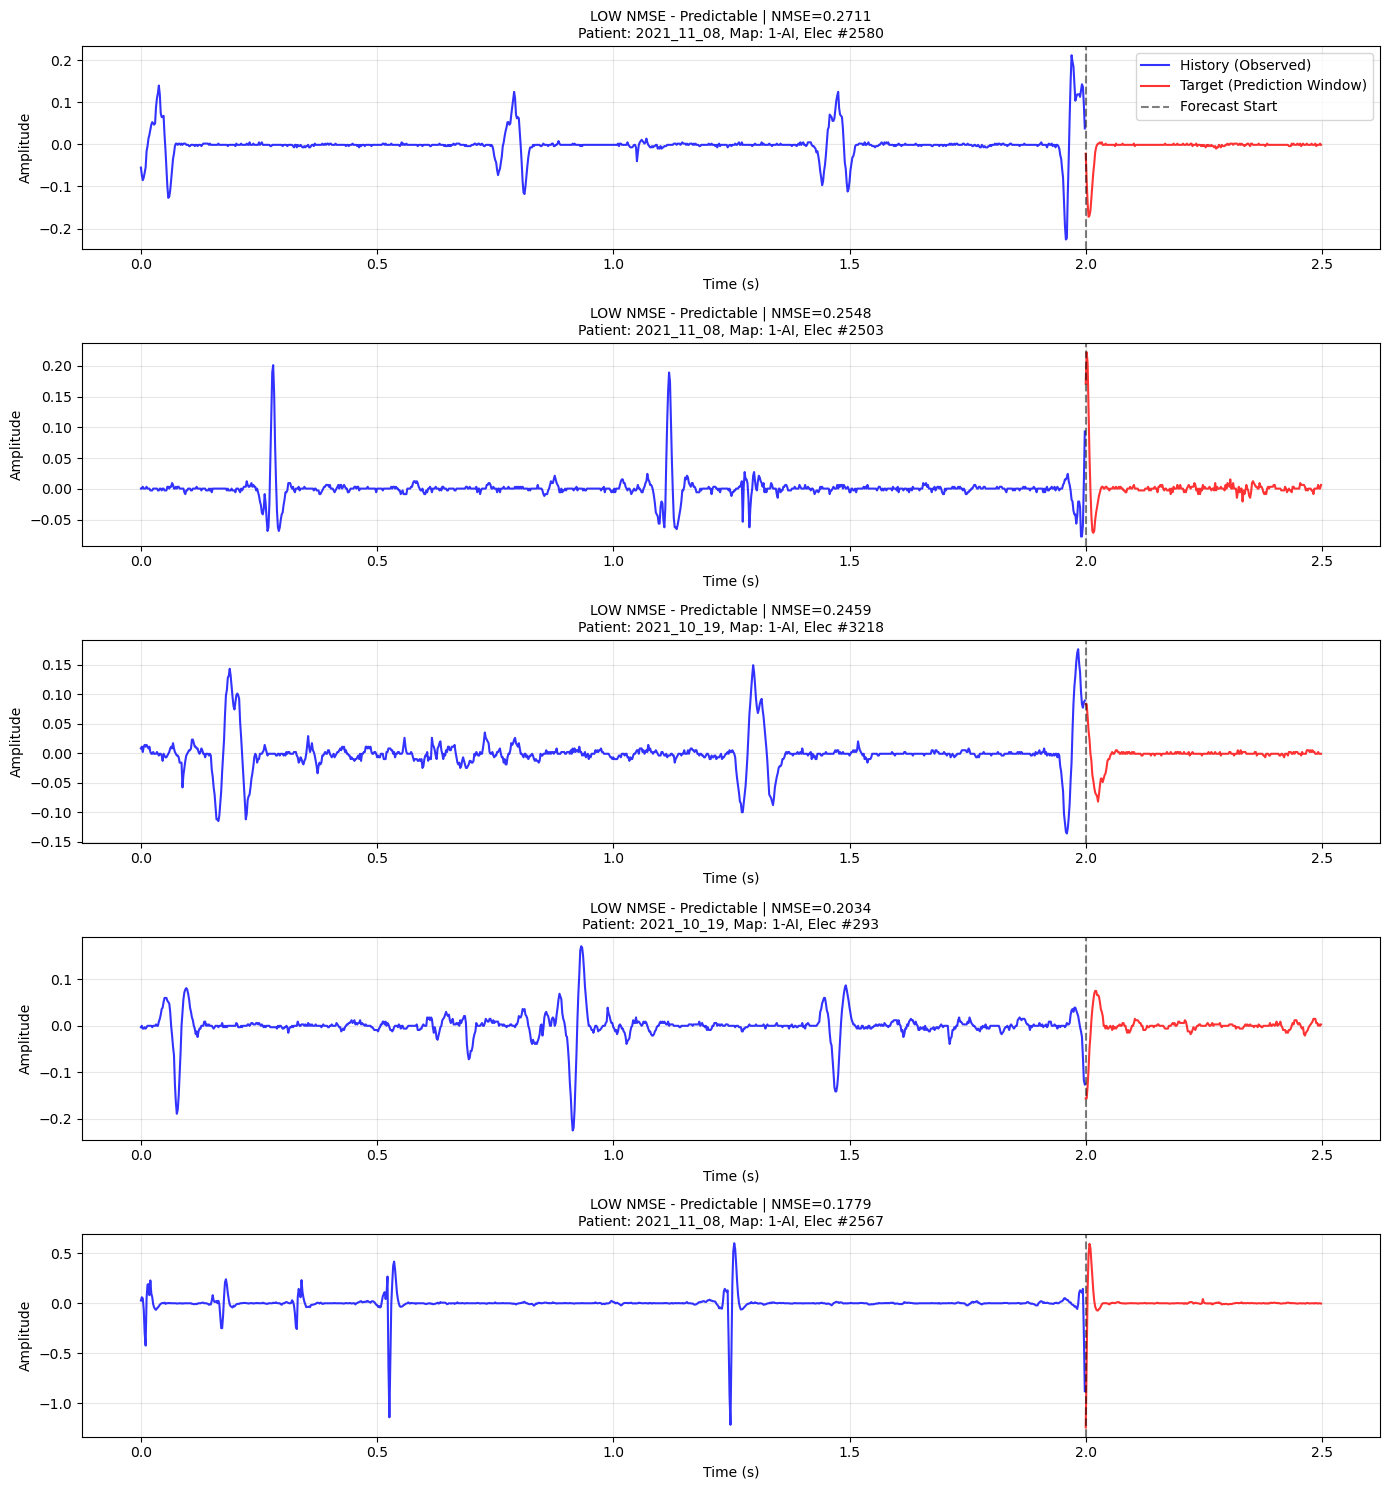

In [50]:
# VISUALIZATION FUNCTION

def plot_anomaly_signals(ranked_df, X_test_history, X_test_target, n_signals=5, top=True):
    """
    Plot the top (most unpredictable) or bottom (most predictable) signals
    """
    if top:
        subset = ranked_df.head(n_signals)
        title_prefix = "HIGH NMSE - Unpredictable"
    else:
        subset = ranked_df.tail(n_signals)
        title_prefix = "LOW NMSE - Predictable"
    
    fig, axes = plt.subplots(n_signals, 1, figsize=(14, 3*n_signals))
    if n_signals == 1:
        axes = [axes]
    
    for i, (ax, (_, row)) in enumerate(zip(axes, subset.iterrows())):
        idx = row['index']
        # Build full signal (history + target)
        full_signal = np.concatenate([X_test_history[idx], X_test_target[idx]])
        time = np.arange(len(full_signal)) / 500  # Convert to seconds
        
        ax.plot(time[:T_OBS], full_signal[:T_OBS], 'b-', label='History (Observed)', alpha=0.8)
        ax.plot(time[T_OBS:], full_signal[T_OBS:], 'r-', label='Target (Prediction Window)', alpha=0.8)
        ax.axvline(x=T_OBS/500, color='k', linestyle='--', alpha=0.5, label='Forecast Start')
        
        # Patient info in title
        patient_info = f"Patient: {row['patient_date']}, Map: {row['map_name']}, Elec #{row['electrode_idx_in_patient']}"
        ax.set_title(f"{title_prefix} | NMSE={row['nmse']:.4f}\n{patient_info}", fontsize=10)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude')
        if i == 0:
            ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot HIGH NMSE signals (potential arrhythmic drivers)
print("=" * 80)
print("HIGH NMSE SIGNALS - Most Unpredictable (Potential Arrhythmic Drivers)")
print("=" * 80)
plot_anomaly_signals(ranked_df, X_test_history, X_test_target, n_signals=5, top=True)

# Plot LOW NMSE signals (healthy/predictable tissue)
print("\n" + "=" * 80)
print("LOW NMSE SIGNALS - Most Predictable (Healthy/Passively Activated Tissue)")
print("=" * 80)
plot_anomaly_signals(ranked_df, X_test_history, X_test_target, n_signals=5, top=False)

HIGH ERROR SIGNALS - Potential Arrhythmic Drivers (CFAEs)
These signals are HARD to predict, suggesting chaotic/complex activity.



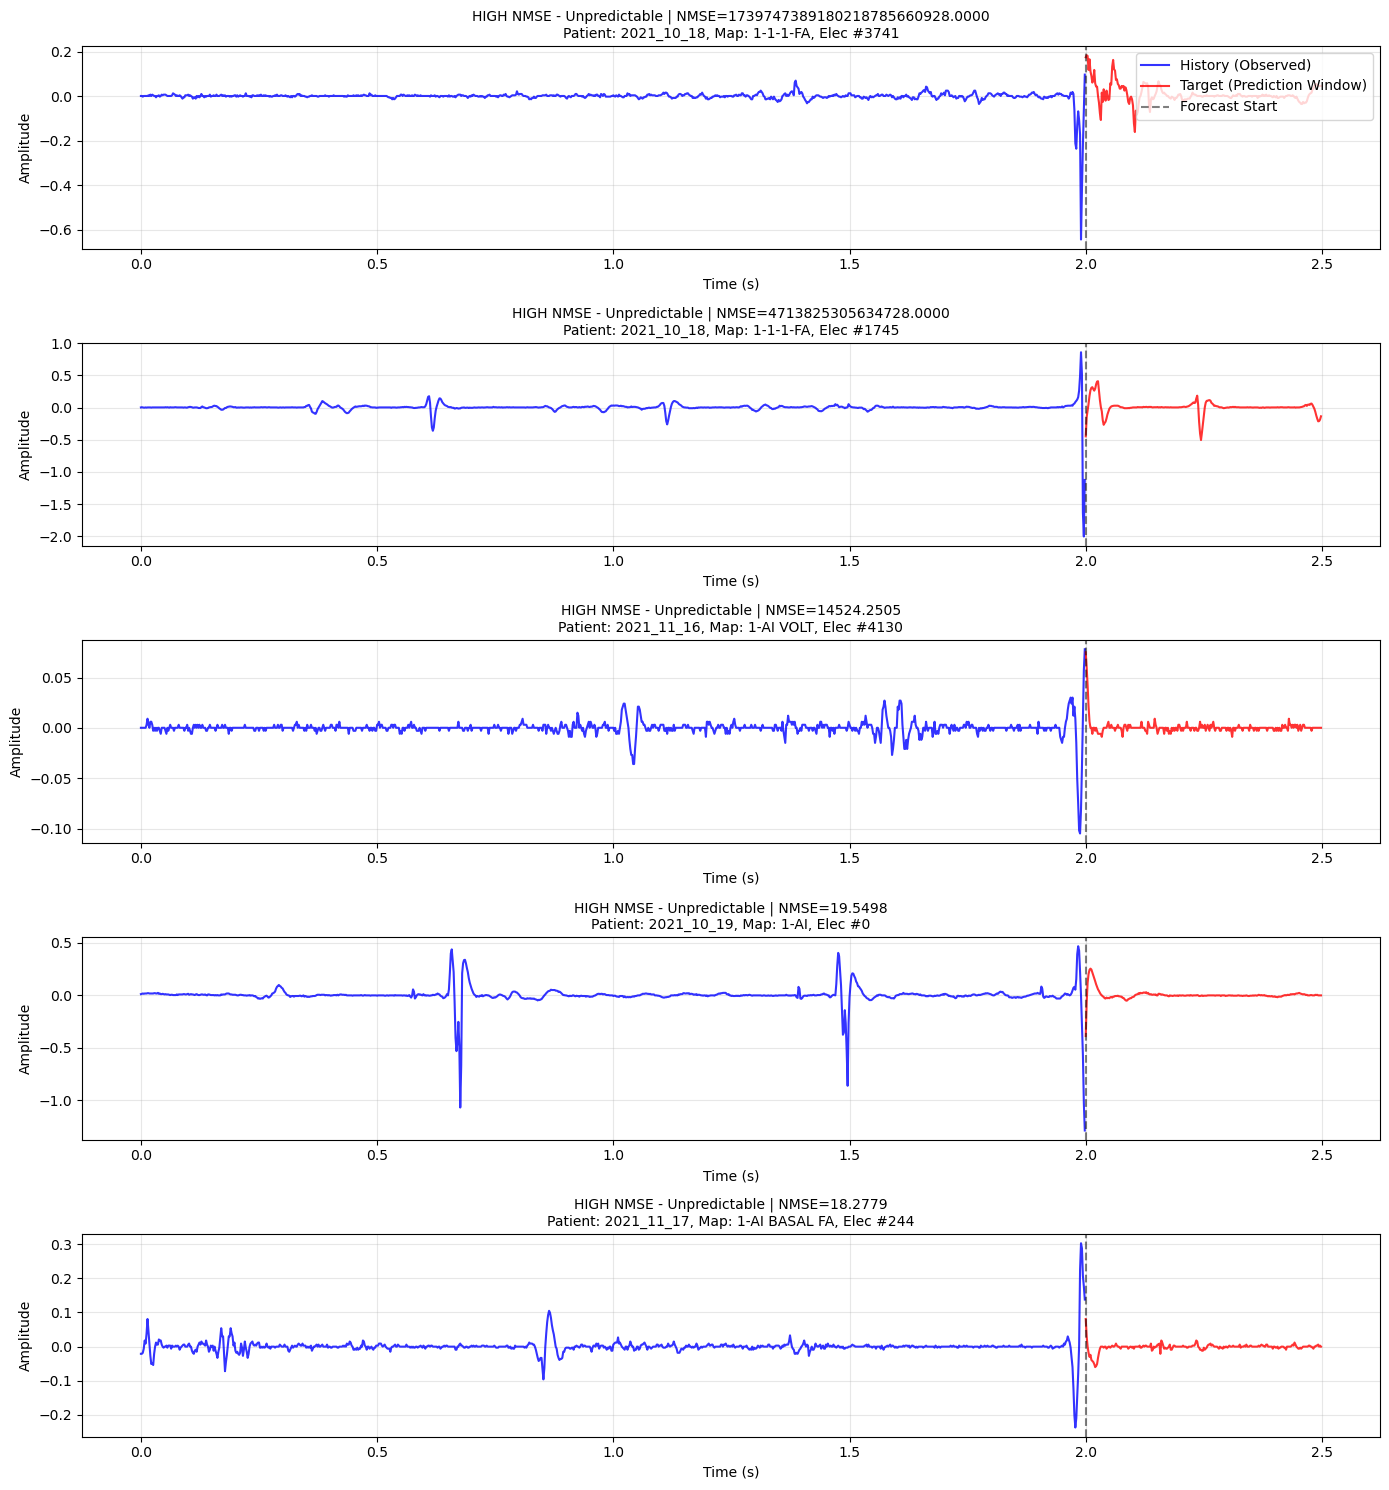

In [51]:
# PLOT TOP-K HIGH ERROR SIGNALS (Potential Arrhythmic Drivers)

K = 5
print("HIGH ERROR SIGNALS - Potential Arrhythmic Drivers (CFAEs)")
print("These signals are HARD to predict, suggesting chaotic/complex activity.\n")

plot_anomaly_signals(ranked_df, X_test_history, X_test_target, n_signals=K, top=True)

LOW ERROR SIGNALS - Healthy / Passively Activated Tissue
These signals are EASY to predict, suggesting organized, regular activity.



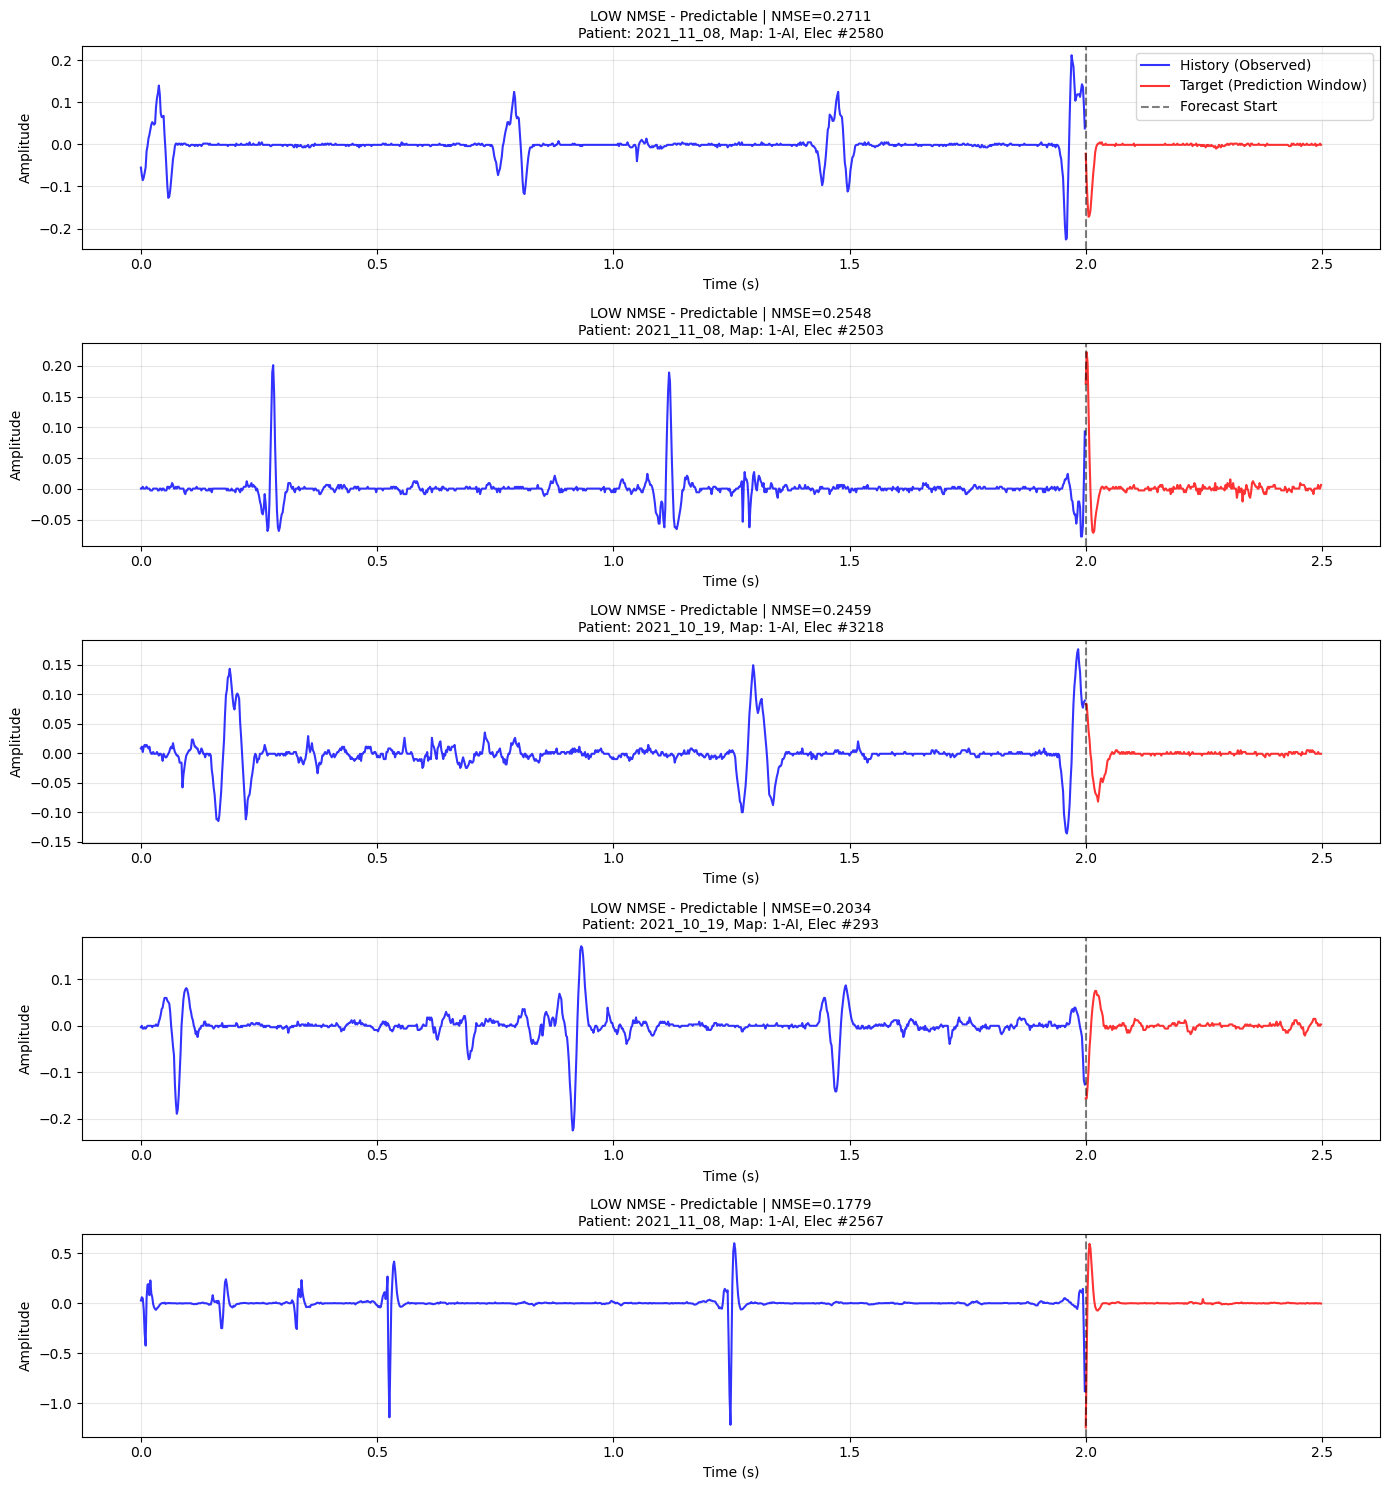

In [52]:
# PLOT TOP-K LOW ERROR SIGNALS (Healthy / Passive Tissue)

print("LOW ERROR SIGNALS - Healthy / Passively Activated Tissue")
print("These signals are EASY to predict, suggesting organized, regular activity.\n")

plot_anomaly_signals(ranked_df, X_test_history, X_test_target, n_signals=K, top=False)

### 8.2. Side-by-Side Comparison

Direct comparison of the most chaotic vs most organized signals to visually validate the hypothesis.

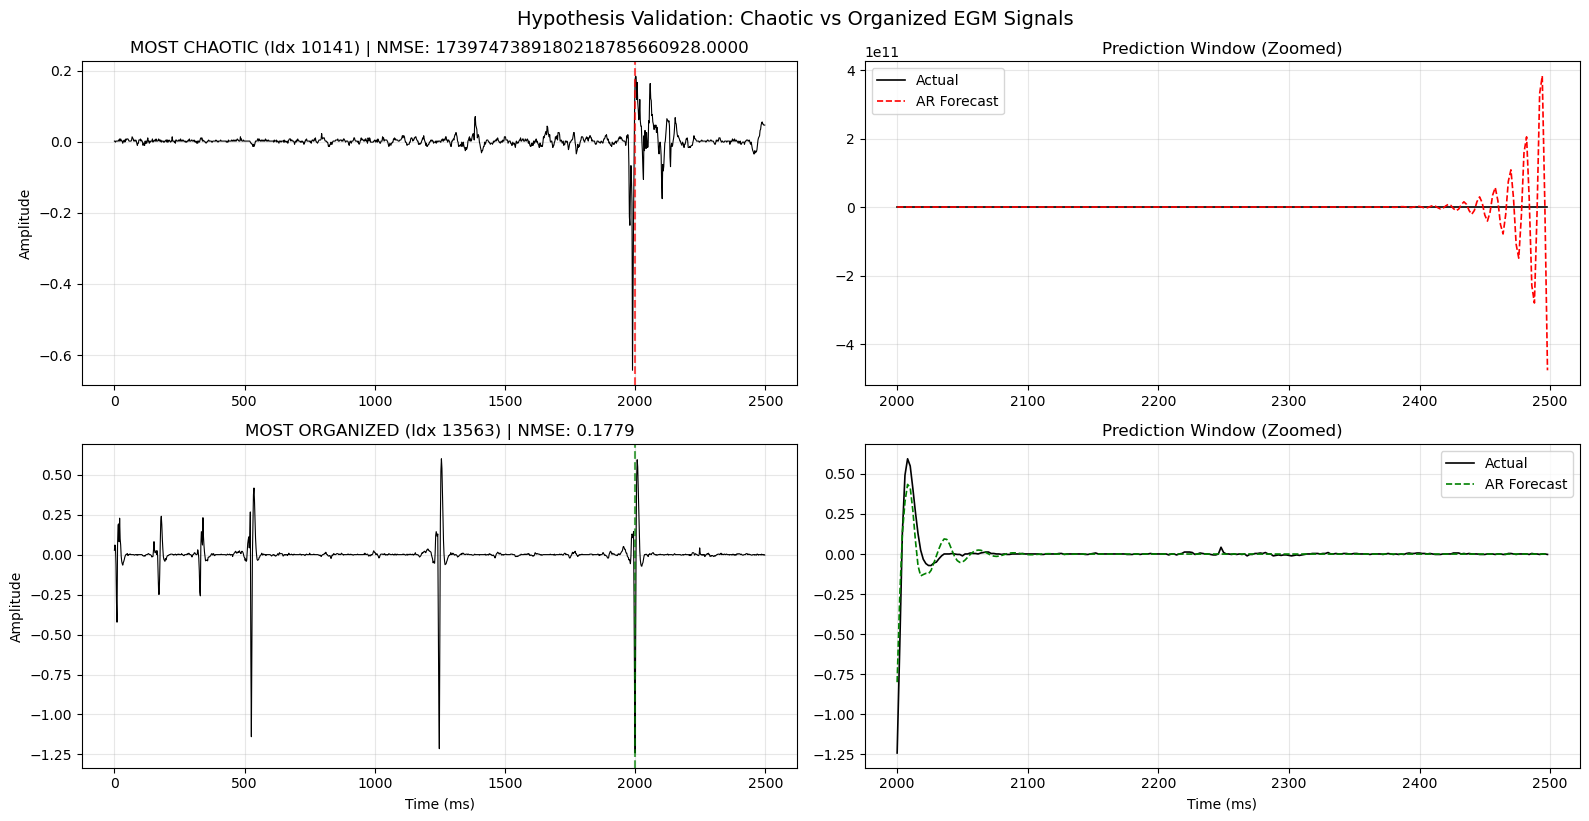

In [53]:
# SIDE-BY-SIDE COMPARISON: Most Chaotic vs Most Organized

fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# Get the single most extreme examples
most_chaotic = ranked_df.iloc[0]
most_organized = ranked_df.iloc[-1]

# Time axes
t_full = np.arange(T) * DT

# Row 1: Most Chaotic (High NMSE)
ax1 = axes[0, 0]
full_signal_chaotic = np.concatenate([most_chaotic['history'], most_chaotic['target']])
ax1.plot(t_full, full_signal_chaotic, 'k-', linewidth=0.8)
ax1.axvline(x=T_OBS * DT, color='red', linestyle='--', alpha=0.7)
ax1.set_title(f"MOST CHAOTIC (Idx {most_chaotic['index']}) | NMSE: {most_chaotic['nmse']:.4f}")
ax1.set_ylabel("Amplitude")
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
t_fut = np.arange(T_OBS, T_OBS + T_PRED) * DT
ax2.plot(t_fut, most_chaotic['target'], 'k-', linewidth=1.2, label='Actual')
ax2.plot(t_fut, most_chaotic['forecast'], 'r--', linewidth=1.2, label='AR Forecast')
ax2.set_title("Prediction Window (Zoomed)")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Row 2: Most Organized (Low NMSE)
ax3 = axes[1, 0]
full_signal_organized = np.concatenate([most_organized['history'], most_organized['target']])
ax3.plot(t_full, full_signal_organized, 'k-', linewidth=0.8)
ax3.axvline(x=T_OBS * DT, color='green', linestyle='--', alpha=0.7)
ax3.set_title(f"MOST ORGANIZED (Idx {most_organized['index']}) | NMSE: {most_organized['nmse']:.4f}")
ax3.set_xlabel("Time (ms)")
ax3.set_ylabel("Amplitude")
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
ax4.plot(t_fut, most_organized['target'], 'k-', linewidth=1.2, label='Actual')
ax4.plot(t_fut, most_organized['forecast'], 'g--', linewidth=1.2, label='AR Forecast')
ax4.set_title("Prediction Window (Zoomed)")
ax4.set_xlabel("Time (ms)")
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle("Hypothesis Validation: Chaotic vs Organized EGM Signals", y=1.02, fontsize=14)
plt.show()

### 8.3. Clinical Summary: Candidate Ablation Sites

Based on the NMSE ranking, we can output a list of electrode indices that represent **potential ablation targets** (high NMSE = chaotic = arrhythmic driver).

In [55]:
# CLINICAL OUTPUT: Candidate Ablation Sites

# Define threshold for "unpredictable" - e.g., top 10% or NMSE > some value
percentile_threshold = 90
nmse_cutoff = np.percentile(anomaly_df['nmse'], percentile_threshold)

# Identify candidate sites
candidate_df = anomaly_df[anomaly_df['nmse'] >= nmse_cutoff][
    ['index', 'patient_date', 'map_name', 'electrode_idx_in_patient', 'nmse', 'mse', 'variance']
].copy()
candidate_df = candidate_df.sort_values('nmse', ascending=False)

print("=" * 90)
print("CLINICAL OUTPUT: CANDIDATE ABLATION SITES")
print("=" * 90)
print(f"Threshold: Top {100 - percentile_threshold}% by NMSE (NMSE >= {nmse_cutoff:.4f})")
print(f"Number of candidates: {len(candidate_df)}")

print("\n" + "-" * 90)
print("Detailed Candidate List:")
print("-" * 90)
print(candidate_df.to_string(index=False))

# Breakdown by patient
print("\n" + "-" * 90)
print("CANDIDATE BREAKDOWN BY PATIENT:")
print("-" * 90)
patient_breakdown = candidate_df.groupby(['patient_date', 'map_name']).agg({
    'index': 'count',
    'nmse': ['mean', 'max']
}).round(4)
patient_breakdown.columns = ['Count', 'Mean NMSE', 'Max NMSE']
print(patient_breakdown)

CLINICAL OUTPUT: CANDIDATE ABLATION SITES
Threshold: Top 10% by NMSE (NMSE >= 1.0214)
Number of candidates: 1596

------------------------------------------------------------------------------------------
Detailed Candidate List:
------------------------------------------------------------------------------------------
 index patient_date                   map_name  electrode_idx_in_patient         nmse          mse  variance
 10141   2021_10_18                   1-1-1-FA                      3741 1.739747e+24 3.017862e+21  0.001735
  4356   2021_10_18                   1-1-1-FA                      1745 4.713825e+15 4.998592e+13  0.010604
  1361   2021_11_16                  1-AI VOLT                      4130 1.452425e+04 7.583102e-01  0.000052
 10721   2021_10_19                       1-AI                         0 1.954983e+01 4.508929e-02  0.002306
  2109   2021_11_17              1-AI BASAL FA                       244 1.827791e+01 2.353353e-03  0.000129
  6203   2021_11_08      

## 9. Final Conclusions

### Summary of Approach
Although AR models fail to accurately predict the precise timing and amplitude of EGM spikes beyond ~100ms, the *prediction error itself* becomes a biomarker for tissue complexity.

### Key Findings
1. **Normalized MSE (NMSE)** provides an amplitude-invariant measure of signal "unpredictability."
2. **High NMSE signals** visually correspond to complex, fractionated activity (potential arrhythmic drivers).
3. **Low NMSE signals** show organized, discrete spikes with clear baselines (healthy/passive tissue).

### Clinical Implication
This approach can help identify **candidate ablation sites** by flagging electrodes where the AR model fails most dramatically. These regions likely represent active arrhythmic drivers or fibrotic tissue that disrupts normal conduction.

### Limitations
- The test set is a subset of the full data; clinical validation would require correlation with actual ablation outcomes.
- The NMSE threshold for "chaotic" is empirical and would need clinical calibration.
- Patient-specific factors (e.g., scar patterns) are not explicitly modeled.